# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/104rep_50noiseLevel_MM_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/105rep_50noiseLevel_MM_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/106rep_50noiseLevel_MM_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/104rep_50noiseLevel_MM_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/105rep_50noiseLevel_MM_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/106rep_50noiseLevel_MM_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.293727        0.194581  0.048480  0.313913  0.020562   
       0.25   0.323736        0.195132  0.045799  0.282352  0.034369   
       0.50   0.328752        0.213141  0.044612  0.252850  0.057399   
       0.75   0.313337        0.202297  0.050766  0.238600  0.082864   
       1.00   0.332999        0.190678  0.043837  0.190445  0.102624   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.193505  0.011086  0.039593  0.049208  0.000000  
       0.25  0.196403  0.007273  0.038744  0.054092  0.000293  
       0.50  0.188675  0.005813  0.038789  0.062074  0.001167  
       0.75  0.193778  0.006923  0.037113  0.061784  0.002147  
       1.00  0.192310  0.007372  0.032795  0.070702  0.003814

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.296320        0.193866  0.048183  0.300890  0.021006   
       0.25   0.334660        0.226282  0.050980  0.300915  0.030855   
       0.50   0.288304        0.203198  0.050705  0.236728  0.059044   
       0.75   0.318042        0.220086  0.044050  0.227060  0.087736   
       1.00   0.312164        0.201038  0.043916  0.194163  0.114352   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.198719  0.009233  0.040941  0.048612  0.000000  
       0.25  0.211786  0.006637  0.040328  0.054974  0.000300  
       0.50  0.209112  0.006668  0.041681  0.060277  0.001115  
       0.75  0.198584  0.006220  0.036579  0.065618  0.002135  
       1.00  0.190290  0.007533  0.035748  0.069783  0.003581

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.332474        0.190093  0.051128  0.309979  0.018826   
       0.25   0.285703        0.199707  0.053459  0.258943  0.033692   
       0.50   0.281070        0.191034  0.047895  0.253231  0.061094   
       0.75   0.306932        0.207326  0.043941  0.226624  0.086481   
       1.00   0.343009        0.199603  0.049213  0.169300  0.106172   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.193980  0.010127  0.040358  0.053954  0.000000  
       0.25  0.173546  0.007515  0.040843  0.051306  0.000291  
       0.50  0.189698  0.006090  0.040191  0.058776  0.001060  
       0.75  0.173729  0.007064  0.036945  0.065506  0.002186  
       1.00  0.186302  0.007834  0.031475  0.072054  0.003474

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.307507        0.192847  0.049264  0.308261  0.020131   
         0.25   0.308498        0.207747  0.054035  0.258928  0.053235   
         0.50   0.282681        0.202640  0.059937  0.187190  0.111983   
         0.75   0.282333        0.208303  0.068492  0.132268  0.156553   
         1.00   0.283047        0.193106  0.078973  0.076945  0.177116   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.195401  0.010149  0.040297  0.050591  0.000000  
         0.25  0.188805  0.011360  0.040084  0.054437  0.000128  
         0.50  0.182363  0.014614  0.040182  0.067011  0.000504  
         0.75  0.169426  0.017583  0.036275  0.079883  0.001038  
         1.00  0.163251  0.020671  0.032536  0.097478  0.001869

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  6.095775e+01  3.830916e+01      36.424600  5.920951e+01   
         0.25  4.562280e+06  2.387218e+06  223584.995860  1.427086e+06   
         0.50  5.504432e+06  3.365541e+06  324725.295380  2.241663e+06   
         0.75  6.091505e+06  4.296528e+06  432146.945852  2.709233e+06   
         1.00  6.135963e+06  4.682593e+06  468004.073384  2.995600e+06   

                                                                        \
                        PMK           PMD          GPPS            Idi   
Strain   Time                                                            
Strain 1 0.00  2.677443e+01  5.322851e+01  5.629791e+01      18.826760   
         0.25  4.627639e+05  2.286100e+06  2.550127e+06  431717.584326   
         0.50  7.122424e+05  3.593802e+06  3.257557e+06  642676.172782   
         0.75  9.261810e+05  4.686807e+06  3.653431e+06  771466.197171   
         1.00  1.020998e+06  5.491013e+06  3.759702e+06  818099.211223   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.699840  
         0.25     183378.398002  
         0.50     290485.416528  
         0.75     339428.322077  
         1.00     411476.812771

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


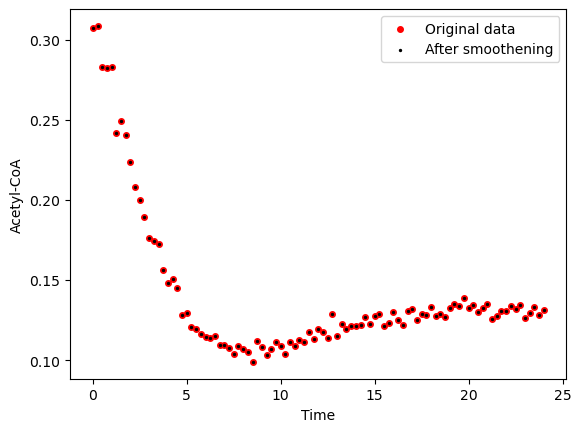

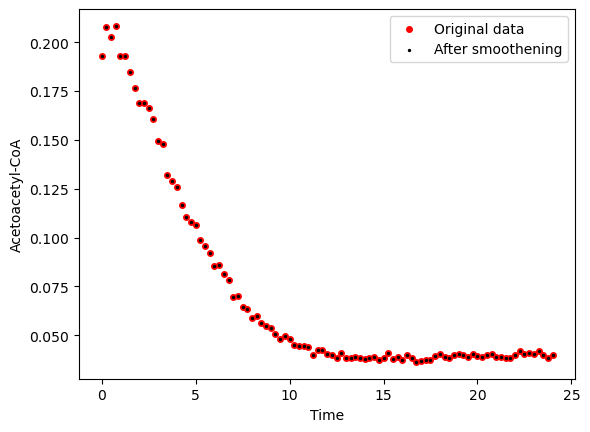

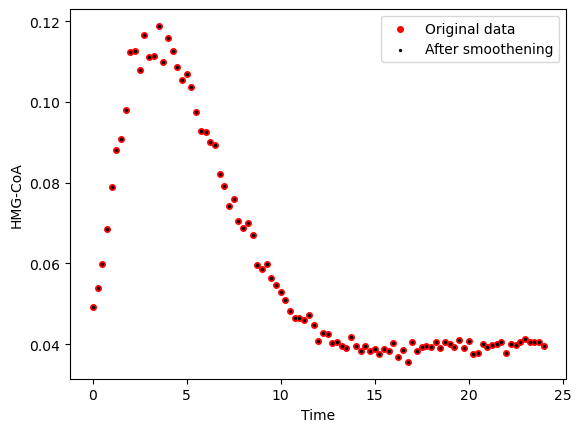

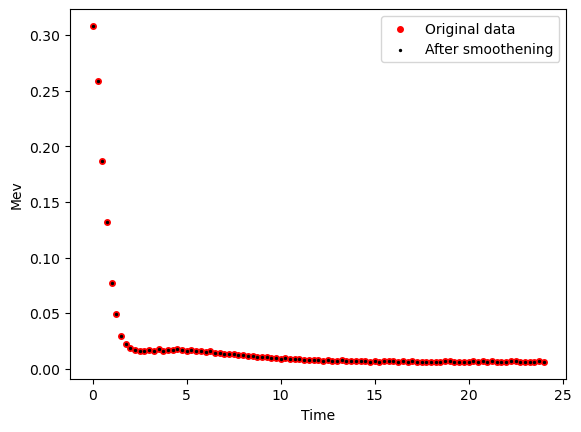

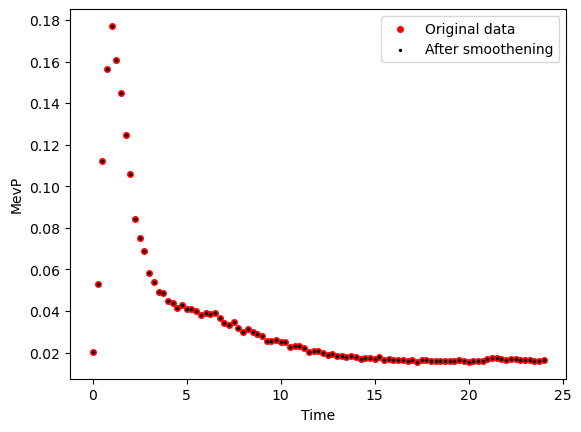

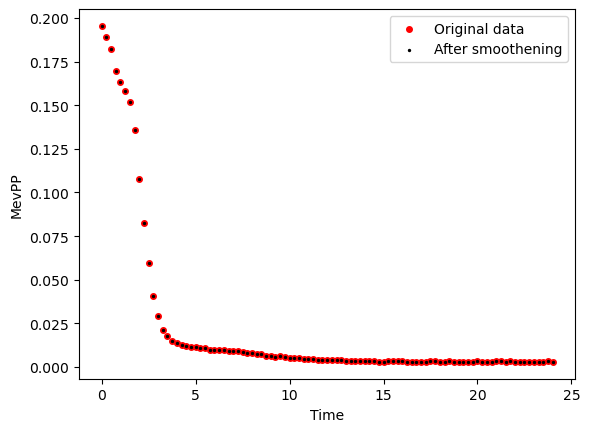

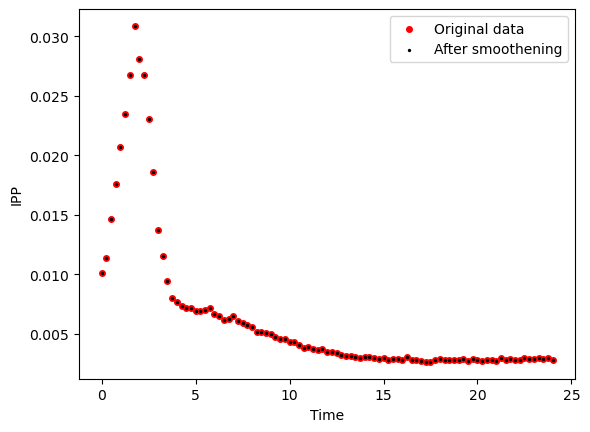

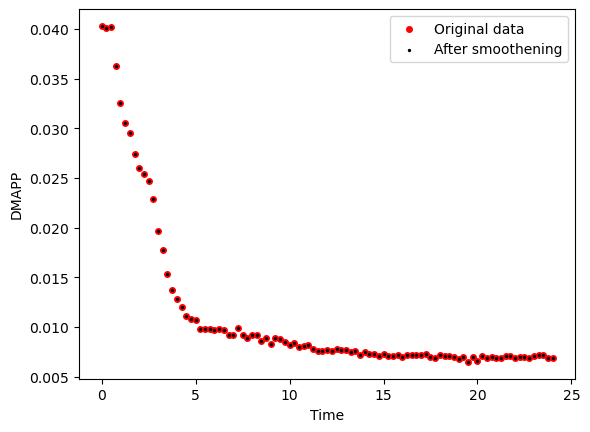

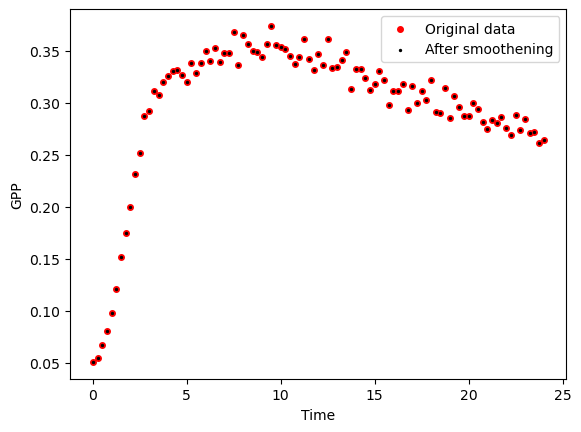

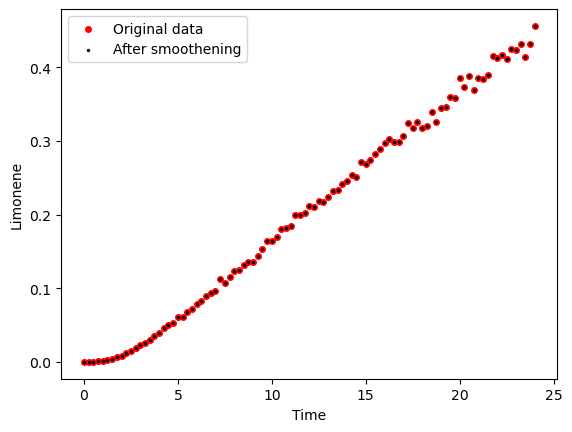

Strain Strain 2


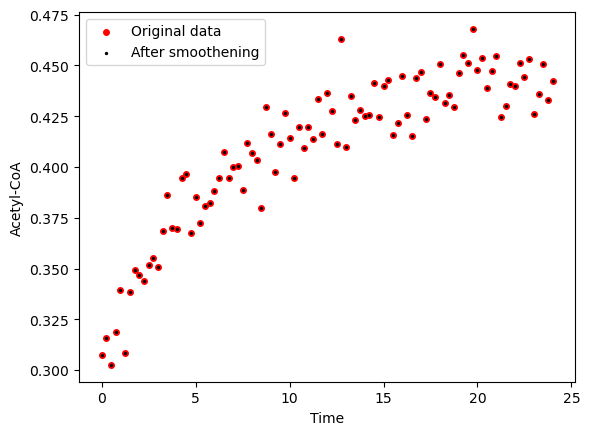

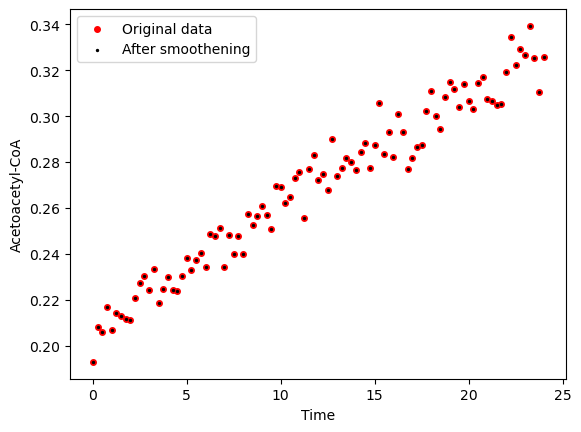

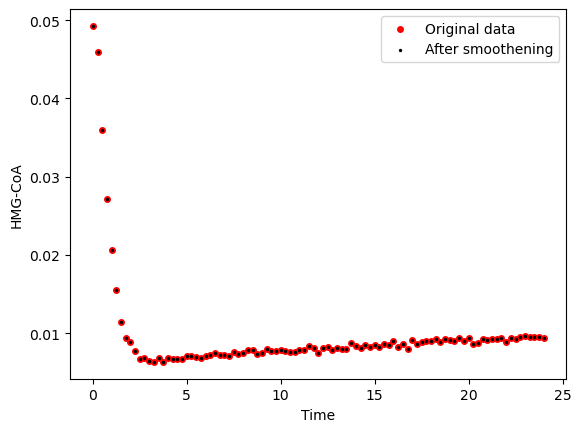

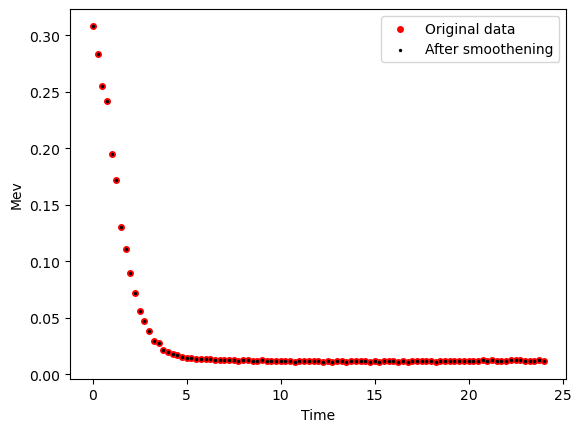

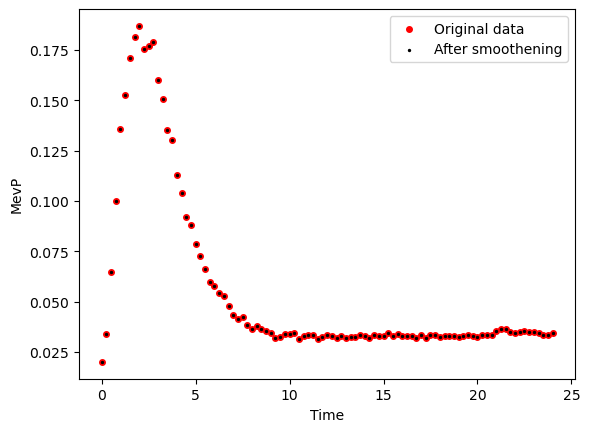

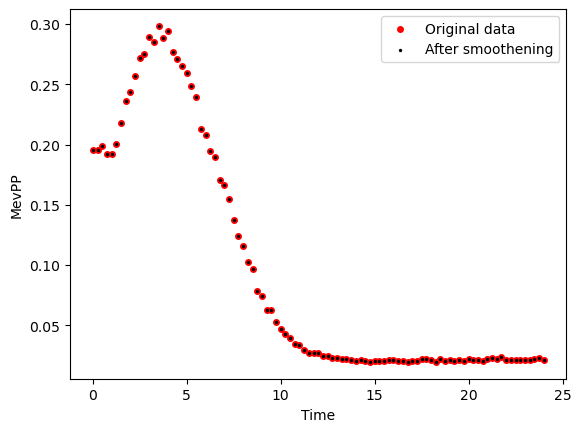

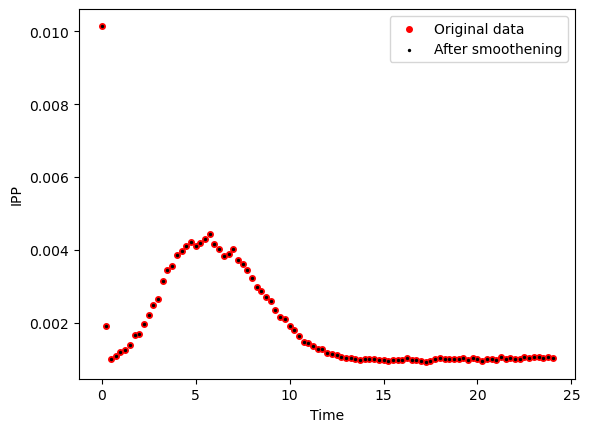

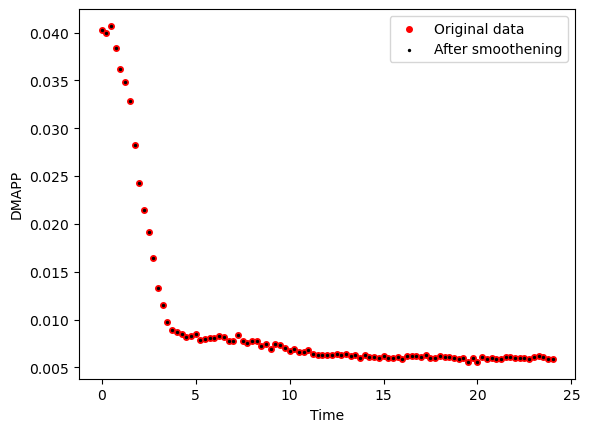

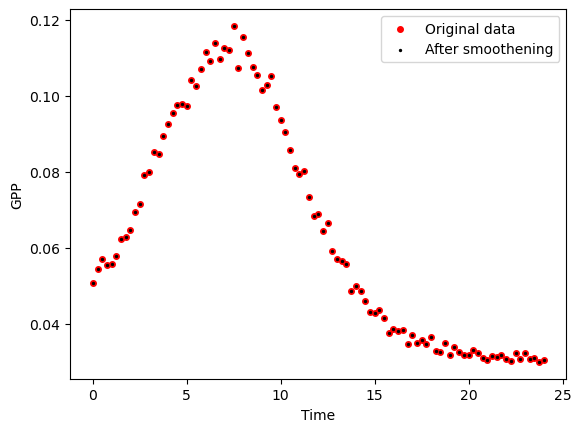

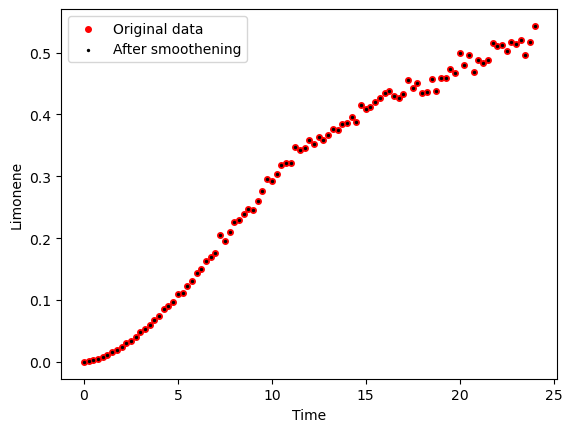

Strain Strain 3


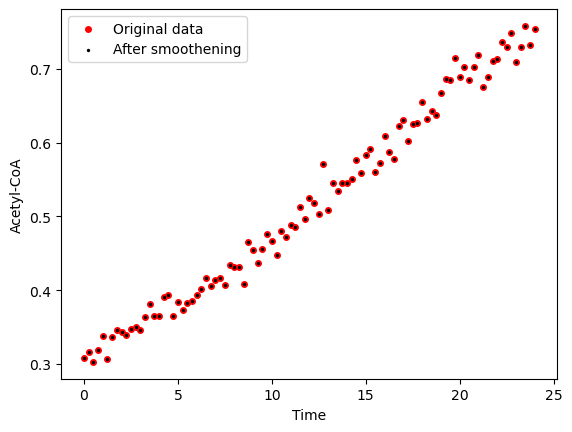

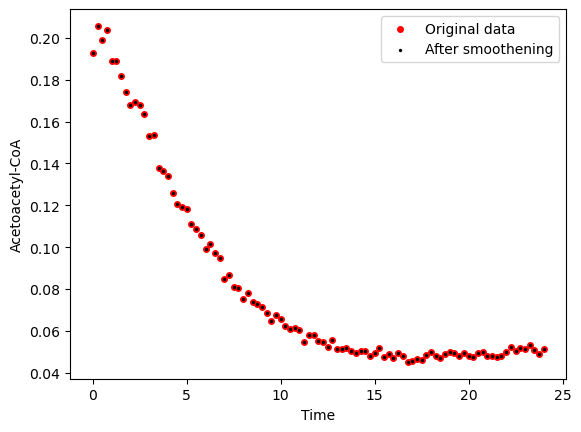

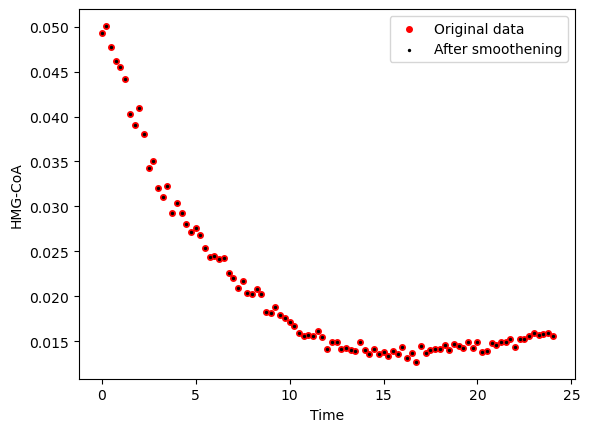

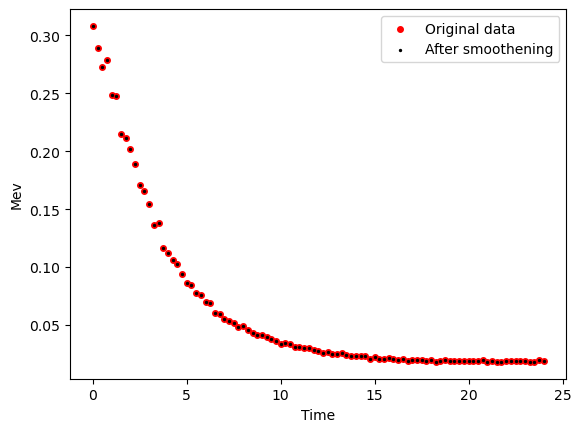

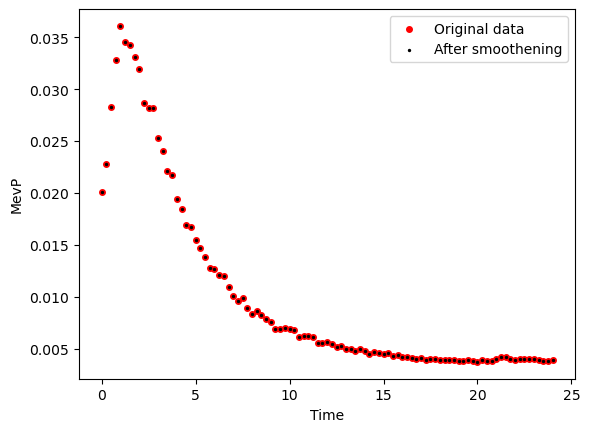

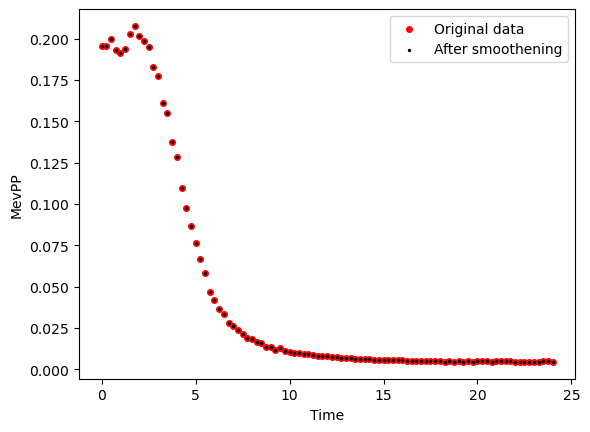

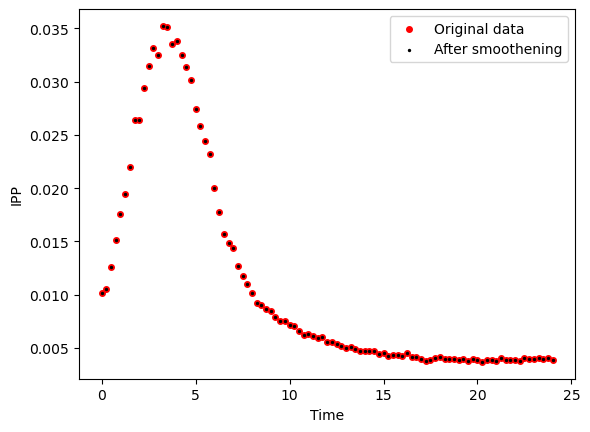

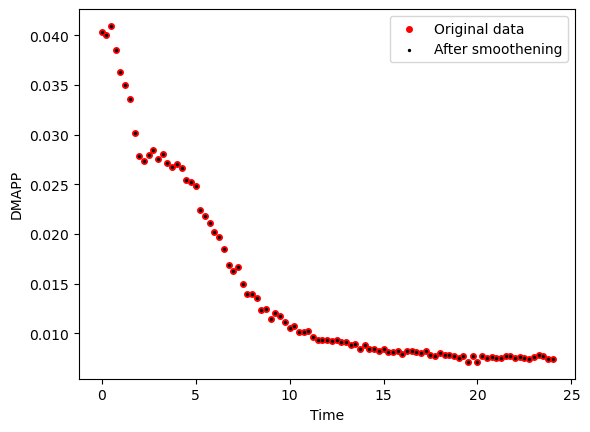

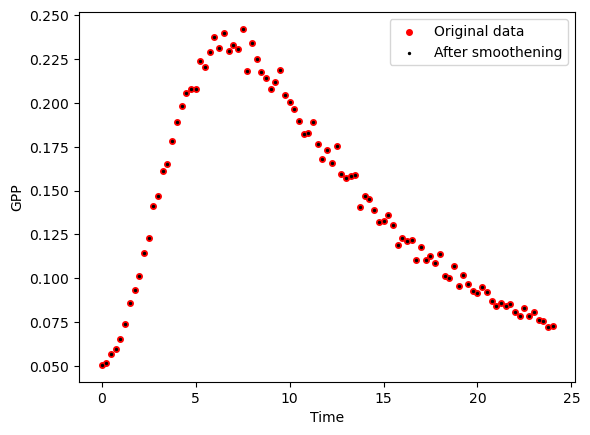

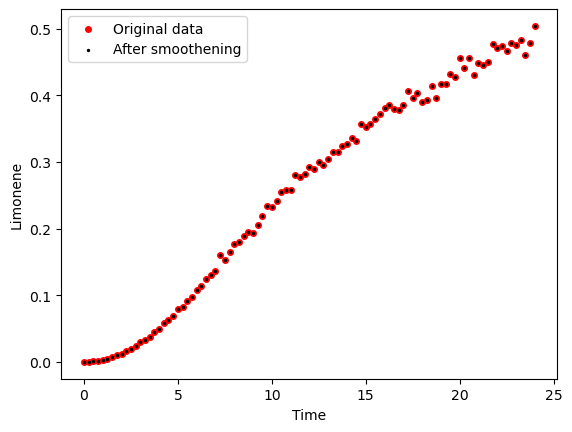

Strain WT


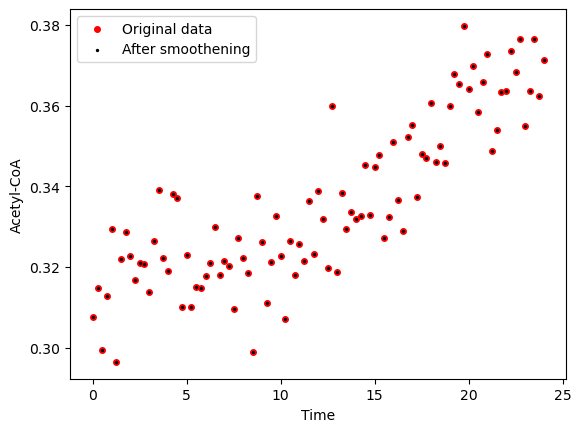

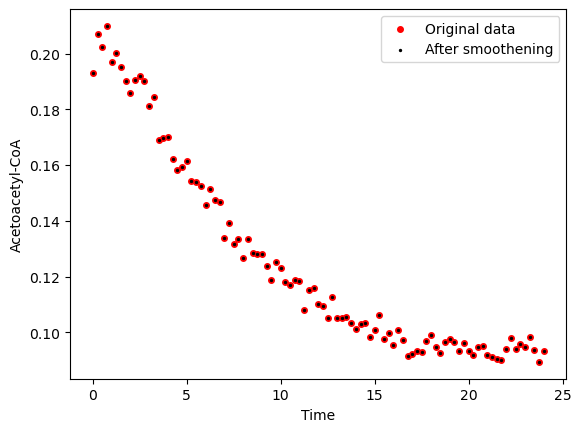

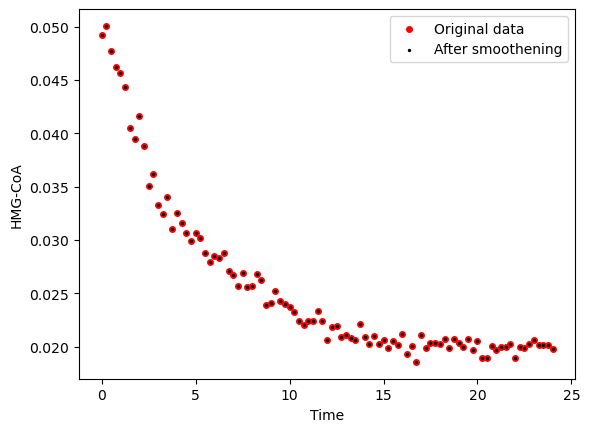

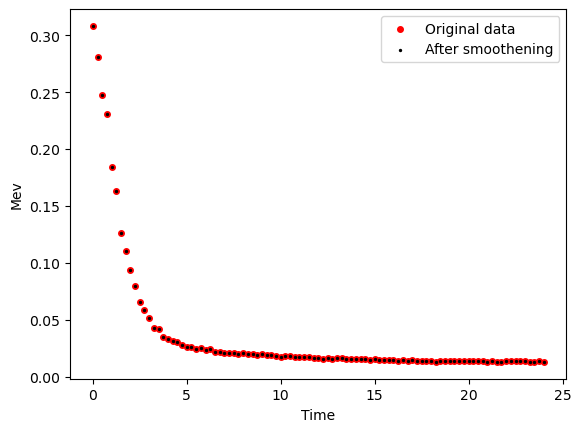

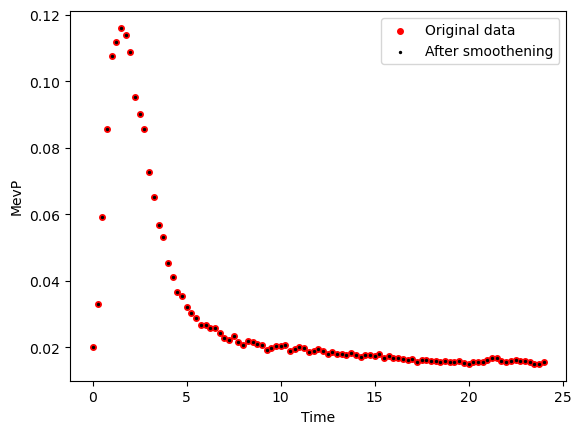

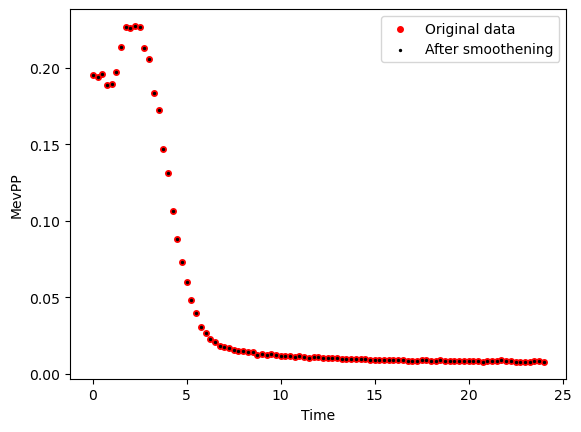

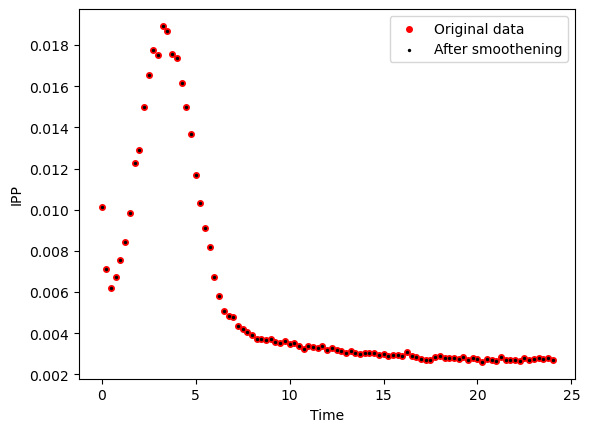

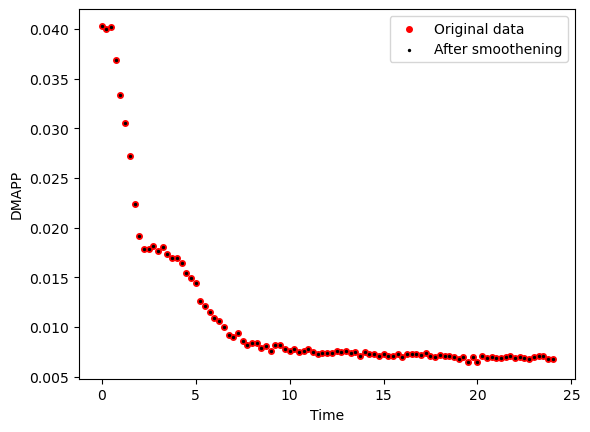

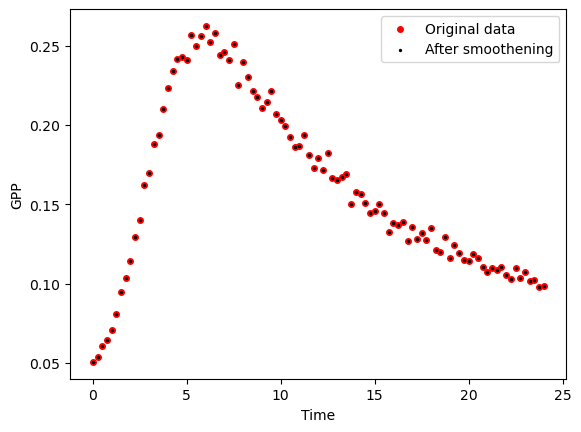

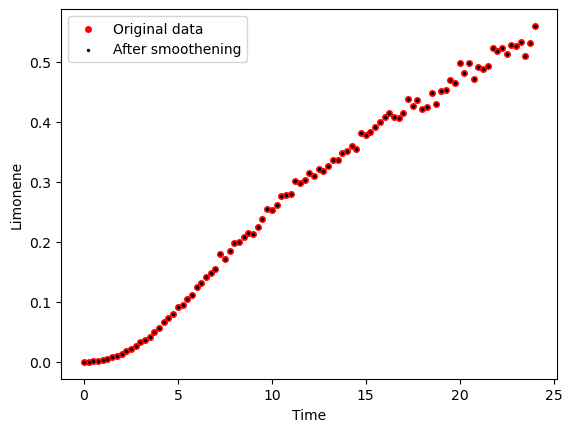

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


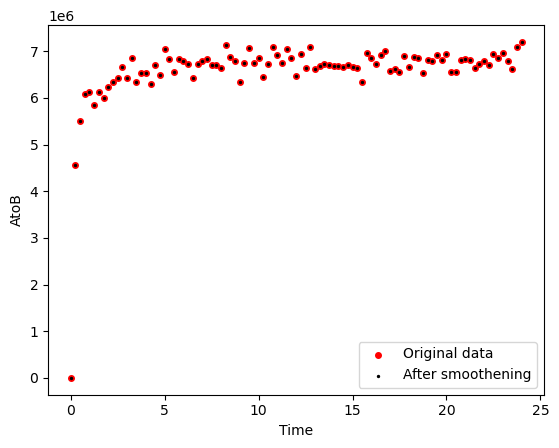

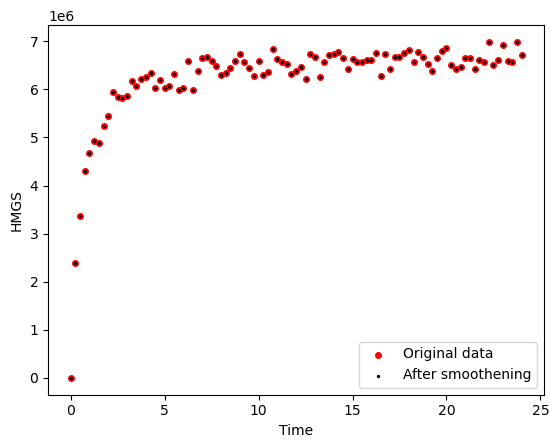

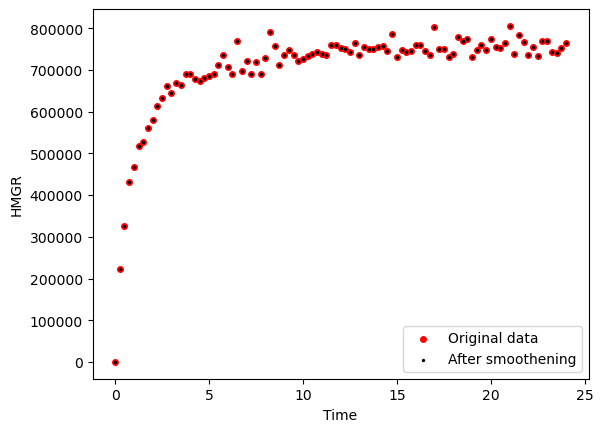

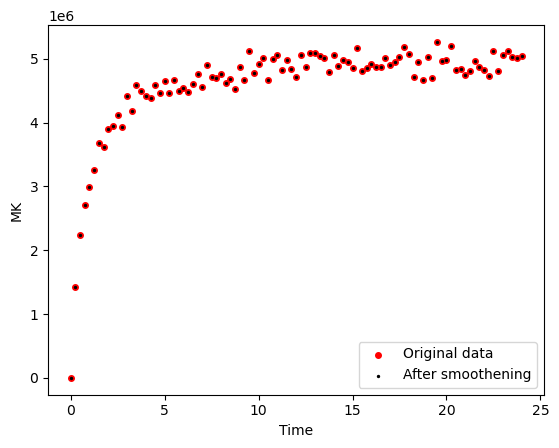

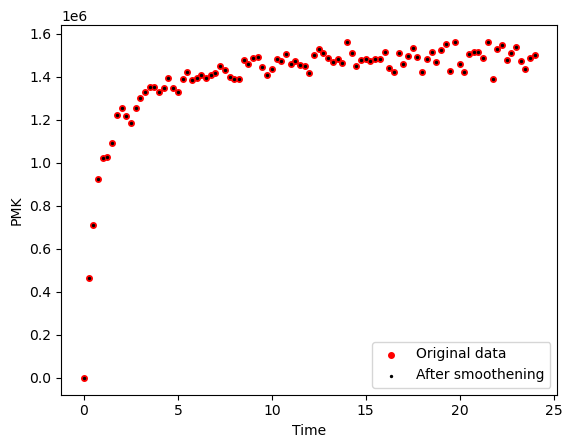

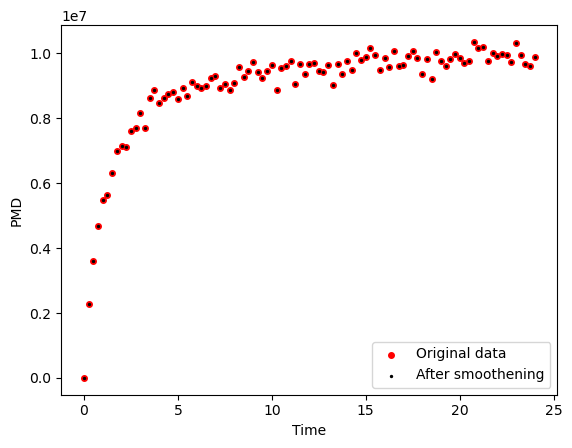

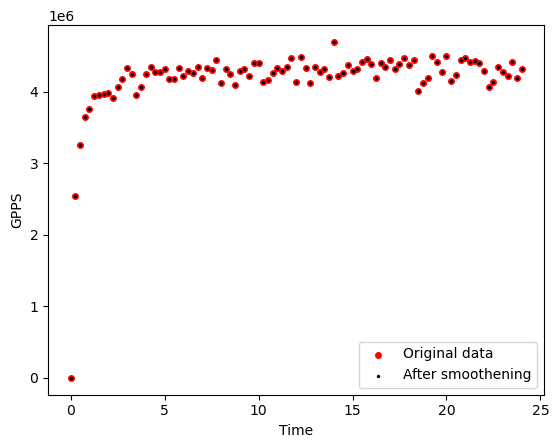

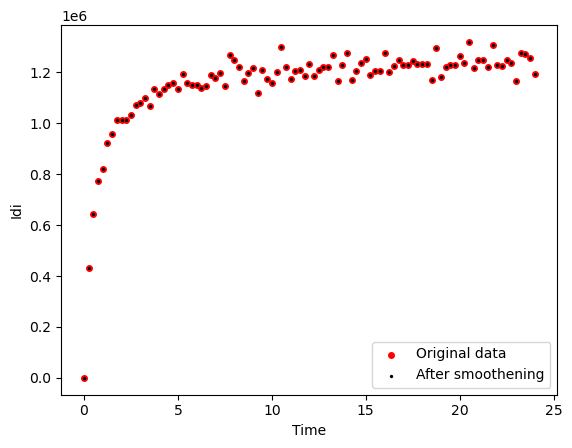

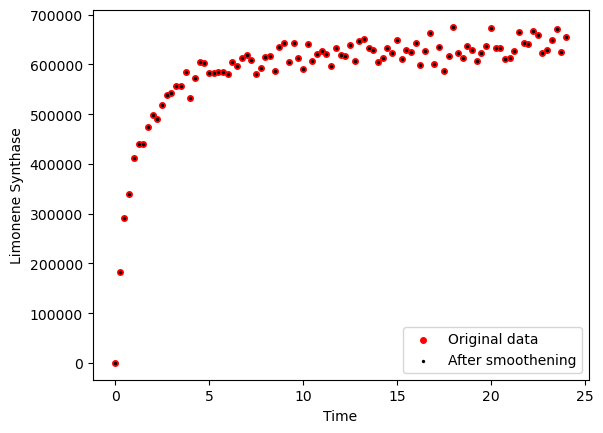

Strain Strain 2


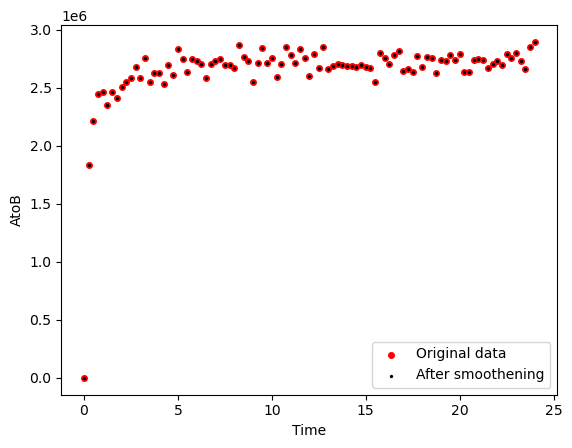

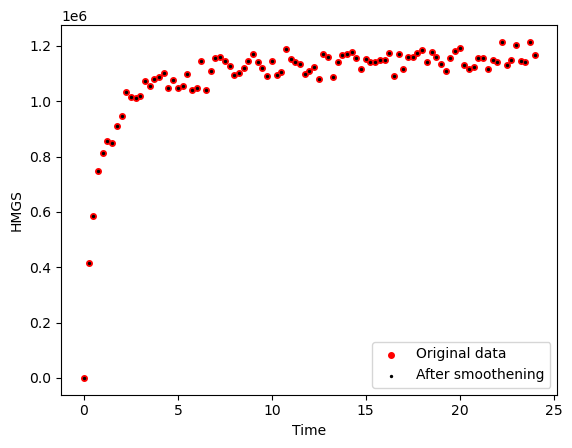

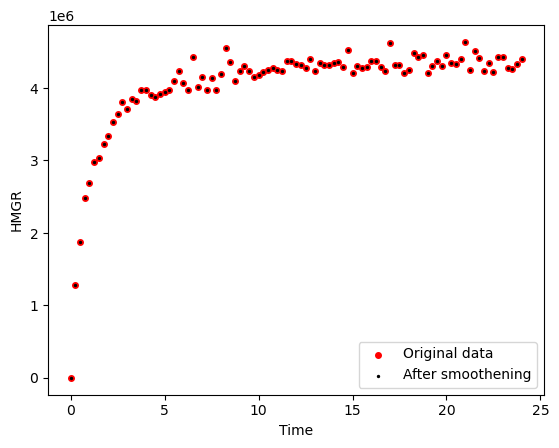

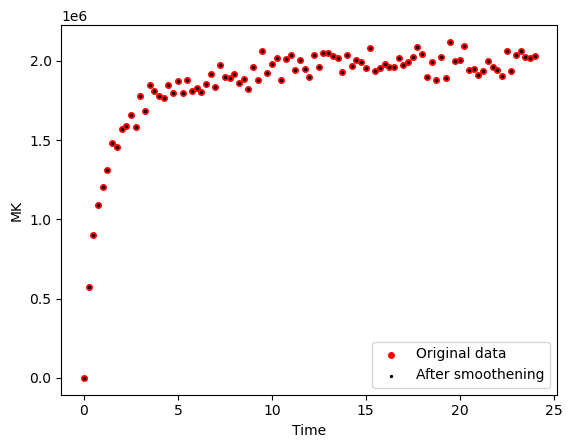

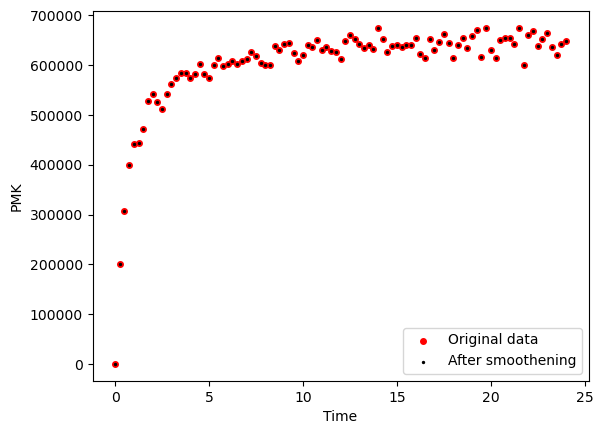

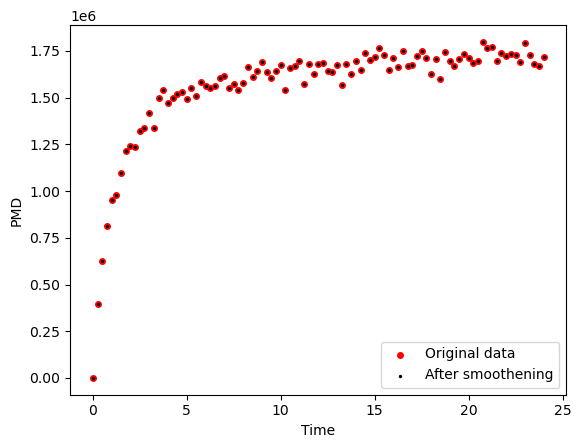

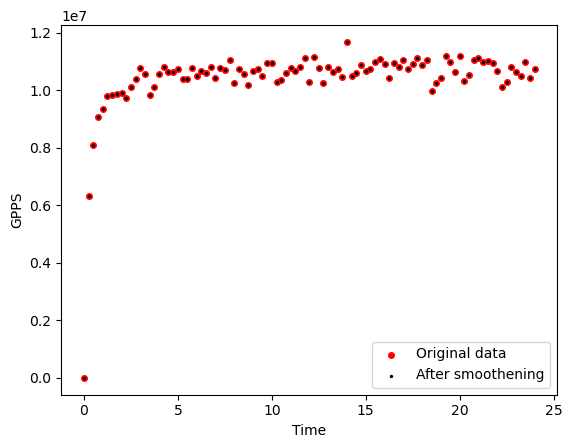

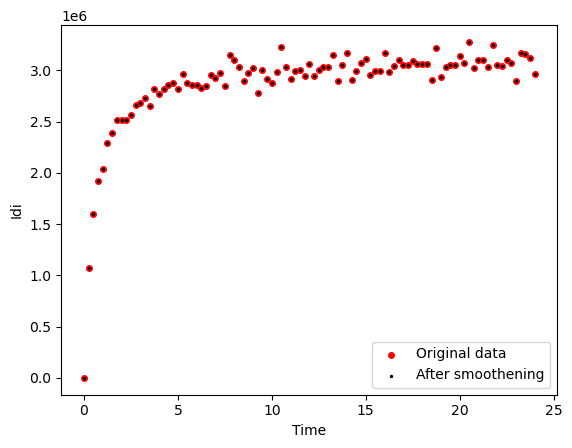

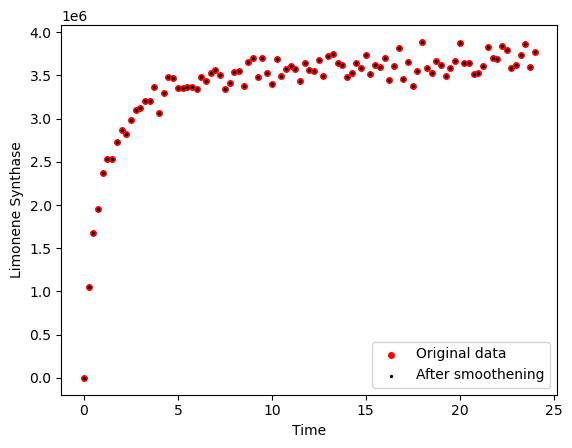

Strain Strain 3


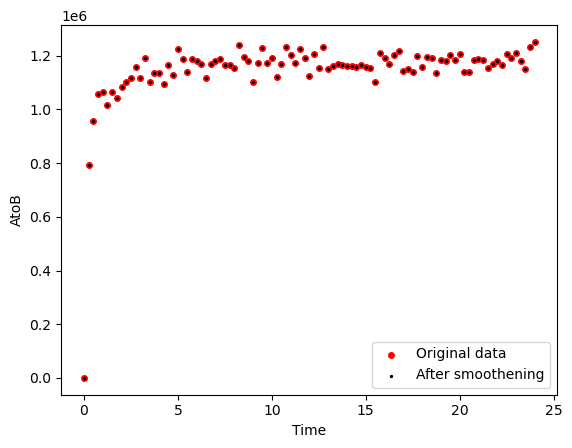

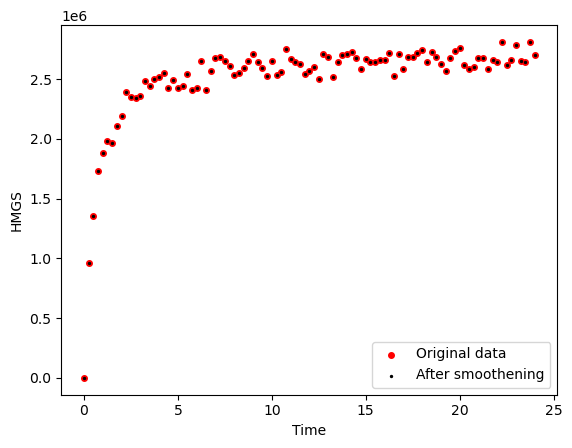

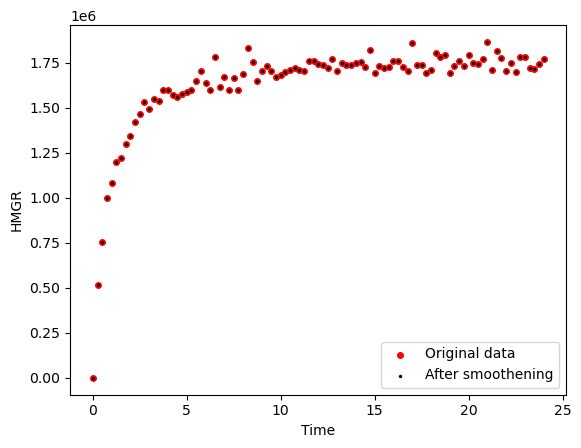

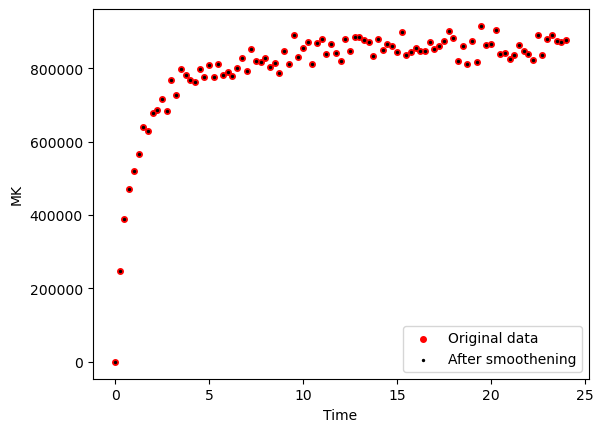

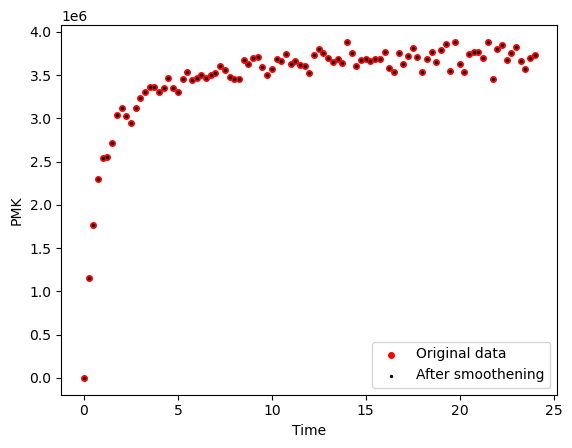

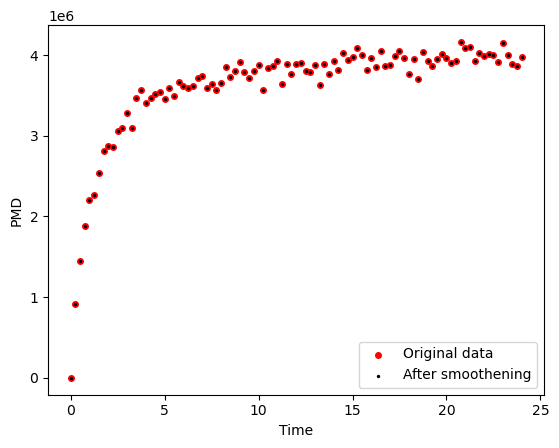

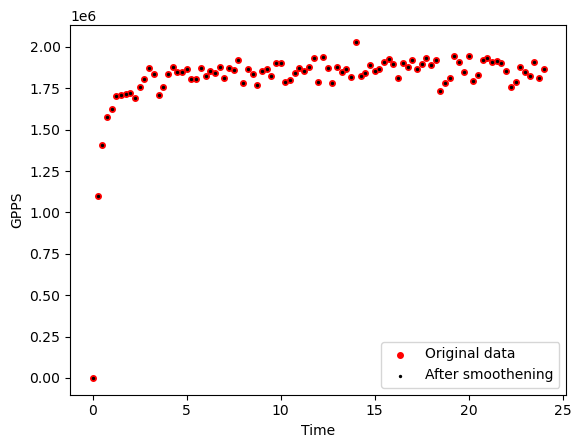

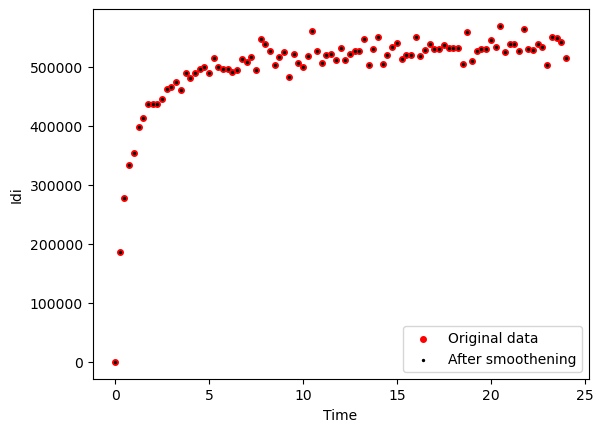

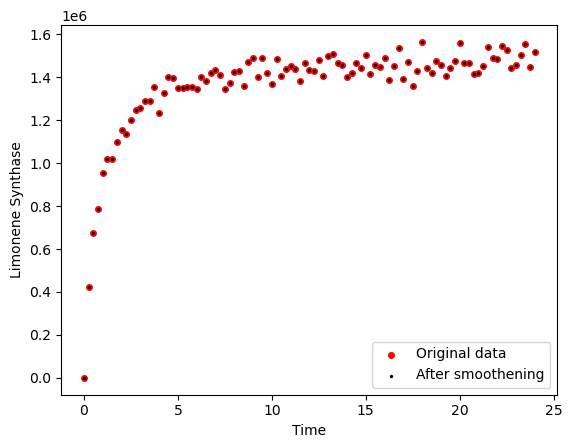

Strain WT


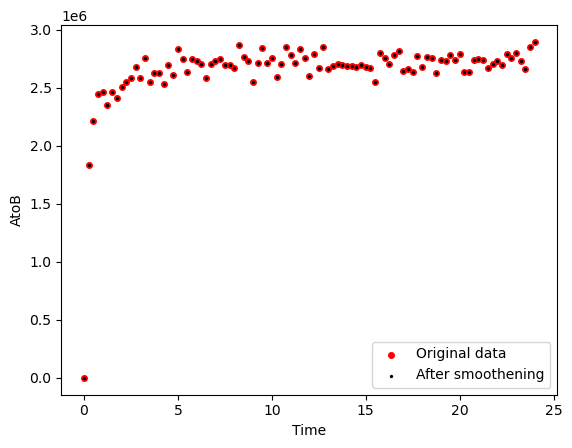

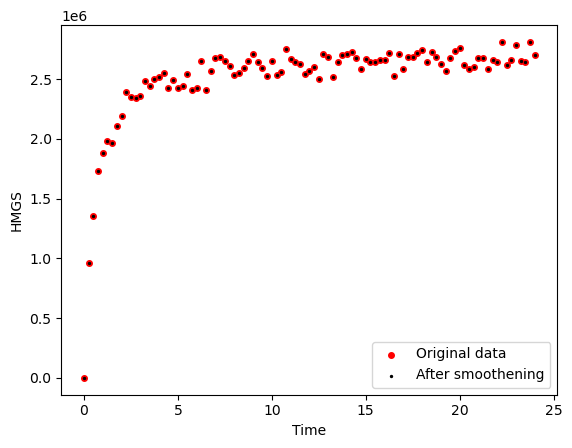

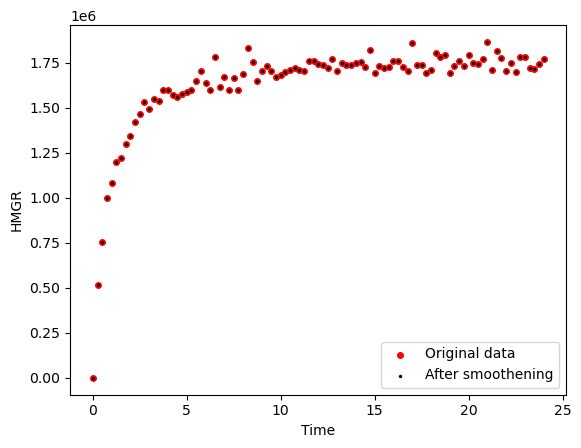

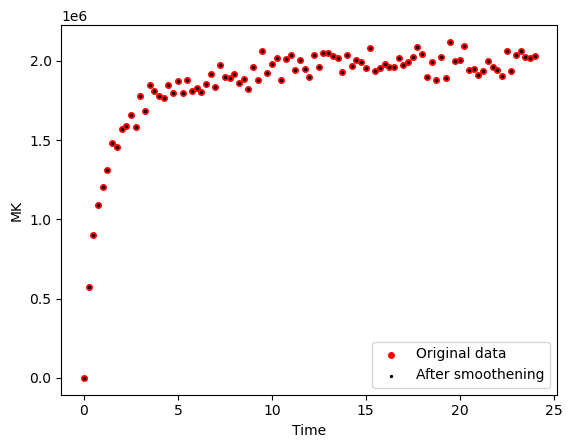

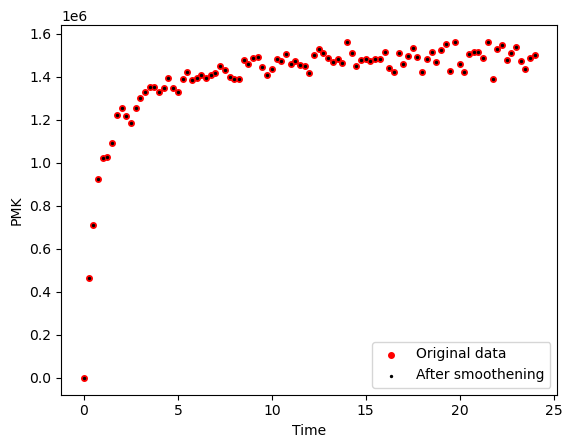

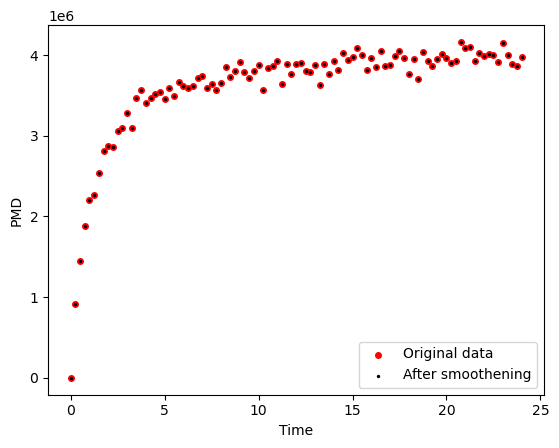

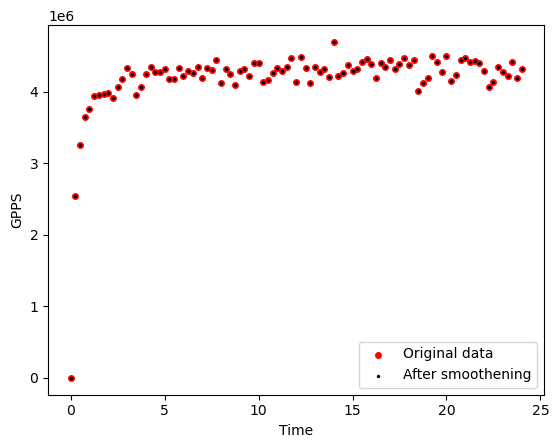

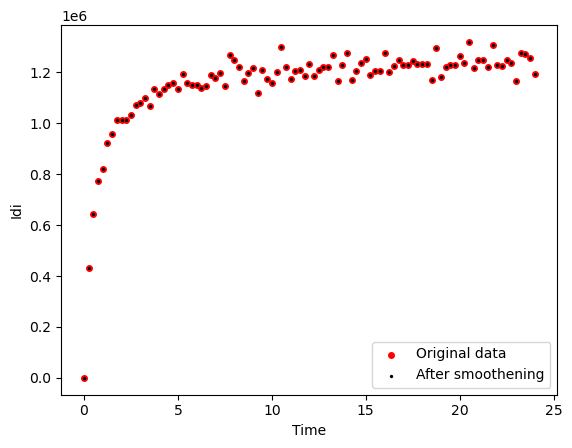

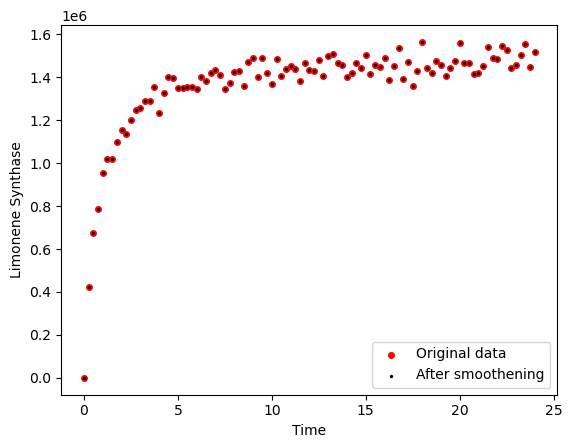

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.307507        0.192847  0.049264  0.308261  0.020131   
         0.25    0.308498        0.207747  0.054035  0.258928  0.053235   
         0.50    0.282681        0.202640  0.059937  0.187190  0.111983   
         0.75    0.282333        0.208303  0.068492  0.132268  0.156553   
         1.00    0.283047        0.193106  0.078973  0.076945  0.177116   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.354902        0.094860  0.020581  0.013272  0.015777   
         23.25   0.363674        0.098216  0.020132  0.012835  0.015516   
         23.50   0.376493        0.093859  0.020200  0.012826  0.015053   
         23.75   0.362412        0.089409  0.020199  0.013463  0.014993   
         24.00   0.371222        0.093427  0.019755  0.013147  0.015445   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.195401  0.010149  0.040297  0.050591  0.000000  ...   
         0.25   0.188805  0.011360  0.040084  0.054437  0.000128  ...   
         0.50   0.182363  0.014614  0.040182  0.067011  0.000504  ...   
         0.75   0.169426  0.017583  0.036275  0.079883  0.001038  ...   
         1.00   0.163251  0.020671  0.032536  0.097478  0.001869  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.007760  0.002749  0.006996  0.107443  0.526609  ...   
         23.25  0.007826  0.002807  0.007125  0.101702  0.534248  ...   
         23.50  0.007997  0.002729  0.007060  0.101965  0.510814  ...   
         23.75  0.008232  0.002796  0.006782  0.097708  0.531937  ...   
         24.00  0.007755  0.002675  0.006810  0.098488  0.560360  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.058510        0.056914  0.013469 -0.241244  0.211782   
         0.25    -0.044272        0.028672  0.021509 -0.238480  0.189348   
         0.50    -0.030034        0.000430  0.029550 -0.235717  0.166914   
         0.75    -0.053172       -0.015574  0.034917 -0.211525  0.112225   
         1.00    -0.043182       -0.020460  0.032531 -0.159233  0.028170   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.001355        0.000656  0.000234 -0.000804 -0.000897   
         23.25   -0.002618       -0.005584 -0.000183 -0.000064 -0.000890   
         23.50    0.012551       -0.004669 -0.000634  0.000151 -0.000475   
         23.75   -0.002777       -0.003966 -0.000668  0.000658  0.000571   
         24.00   -0.018106       -0.003262 -0.000703  0.001164  0.001616   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.027011  0.006942  0.004903  0.015920  0.000071  
         0.25  -0.030241  0.008924 -0.001415  0.031804  0.000965  
         0.50  -0.033472  0.010907 -0.007733  0.047688  0.001860  
         0.75  -0.032231  0.012136 -0.010665  0.065499  0.002841  
         1.00  -0.028907  0.012110 -0.010773  0.084166  0.004056  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.000220 -0.000014  0.000262 -0.006946 -0.000693  
         23.25  0.000392  0.000056 -0.000004 -0.006922 -0.004265  
         23.50  0.000158 -0.000064 -0.000286 -0.008761  0.026076  
         23.75 -0.000426 -0.000187 -0.000524 -0.003893  0.075290  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

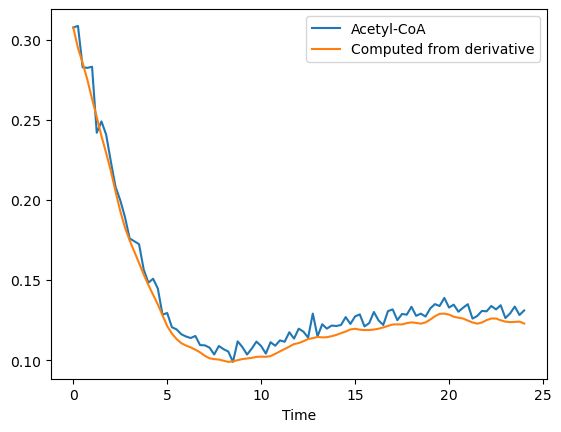

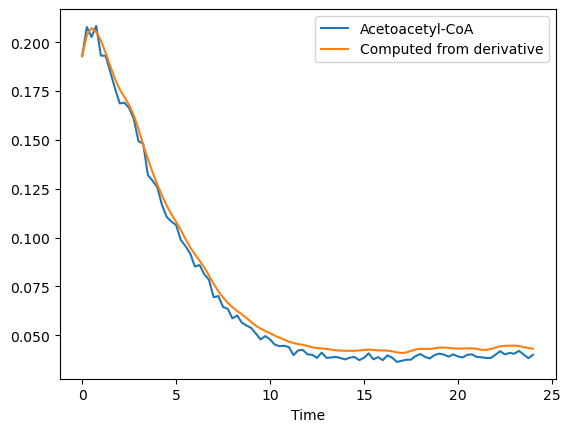

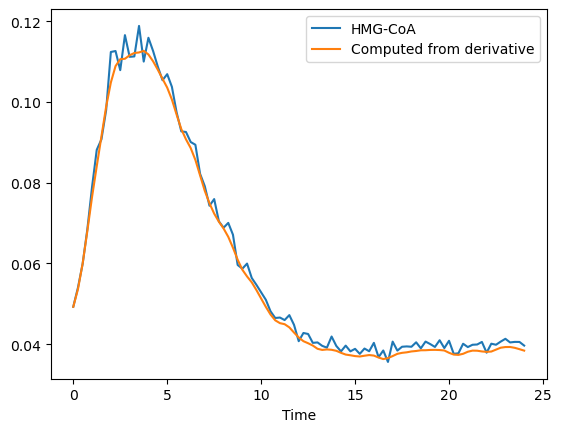

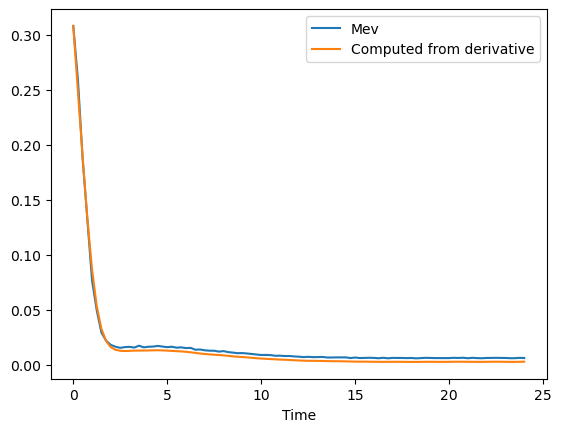

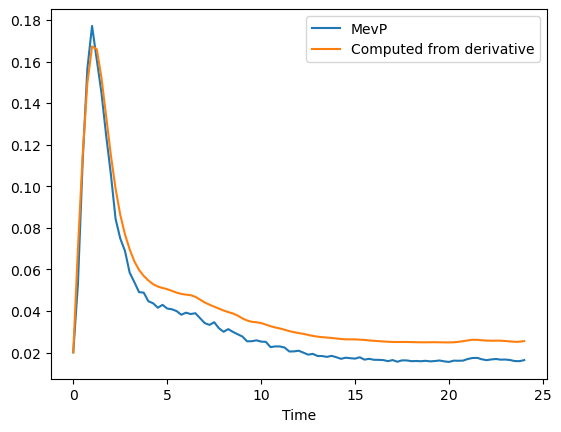

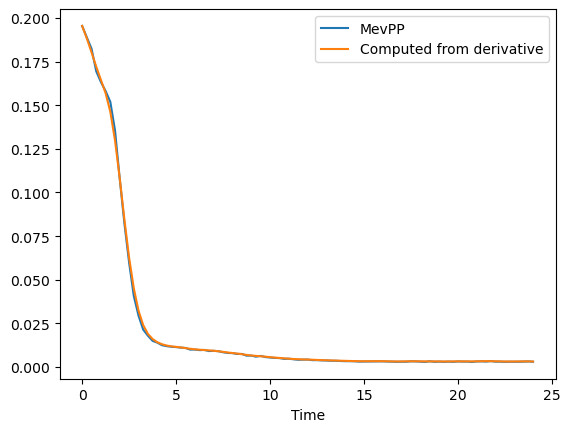

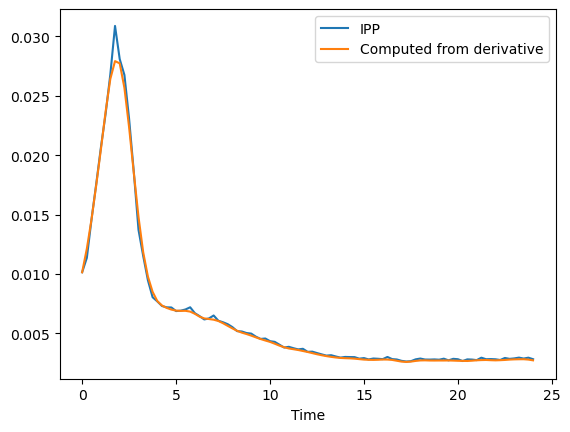

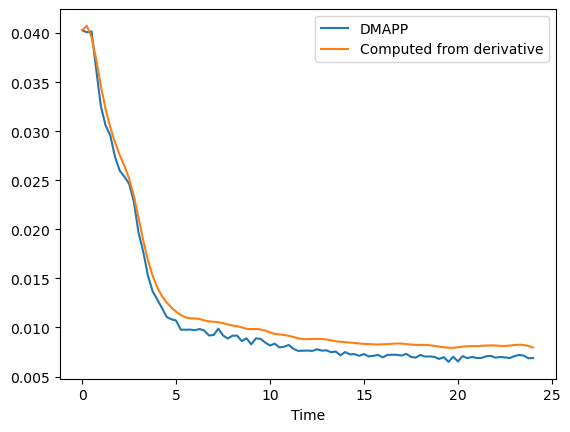

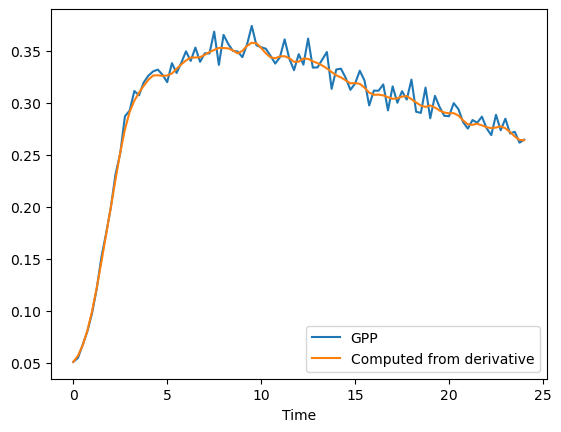

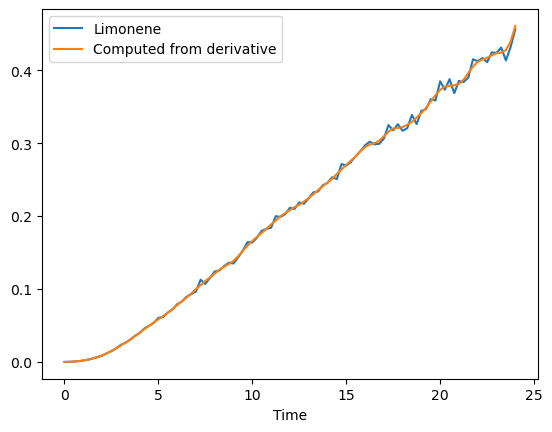

'Time profile from derivative vs. actual profile for Strain 2'

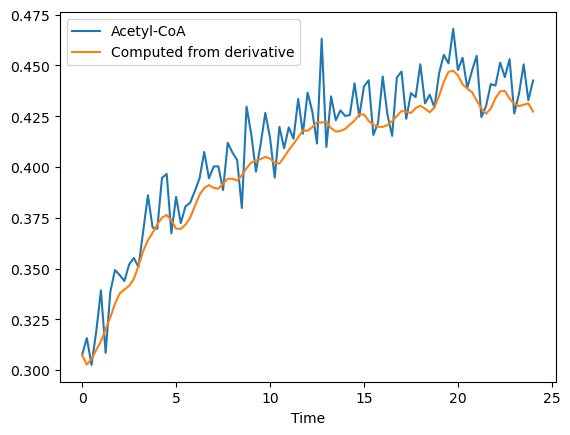

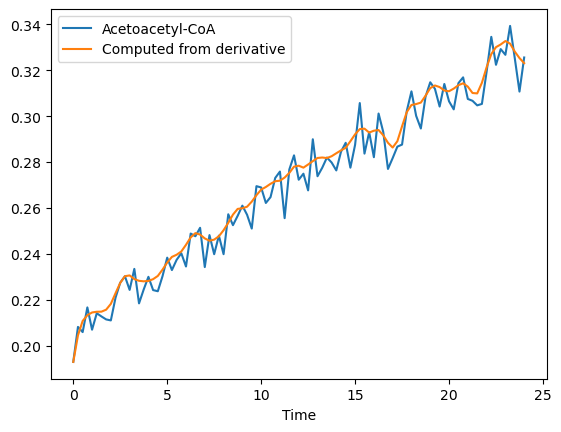

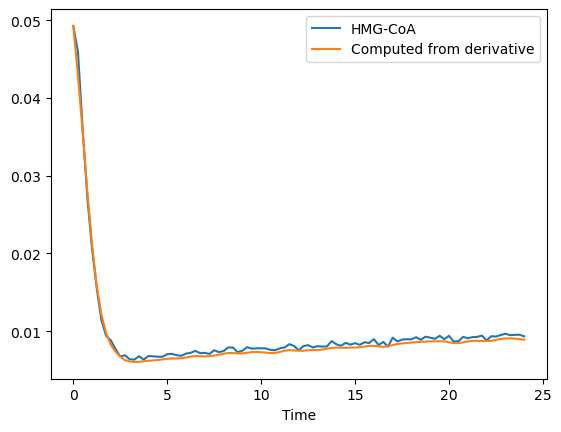

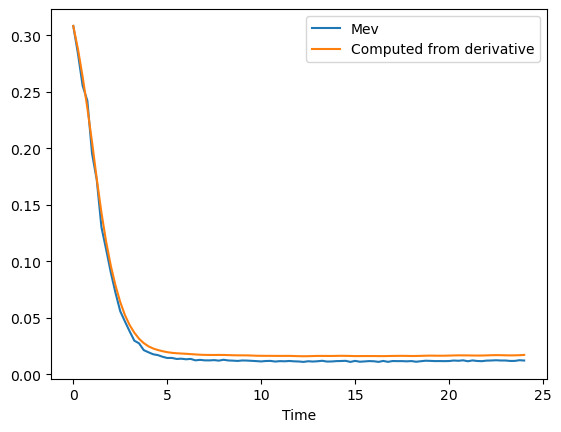

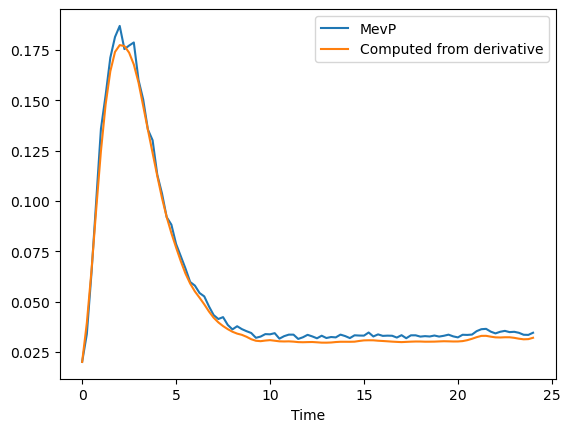

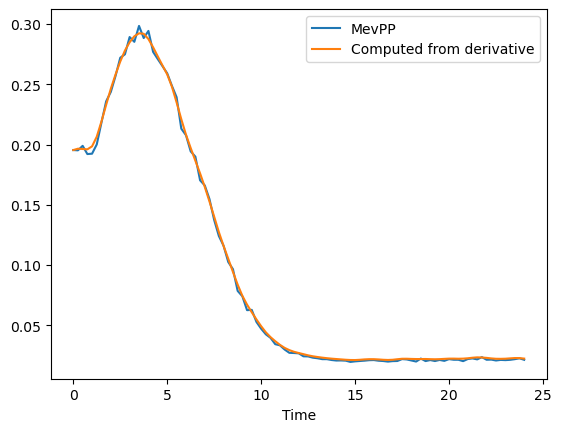

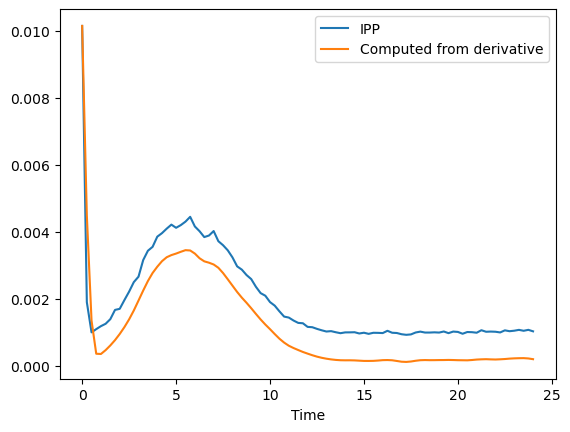

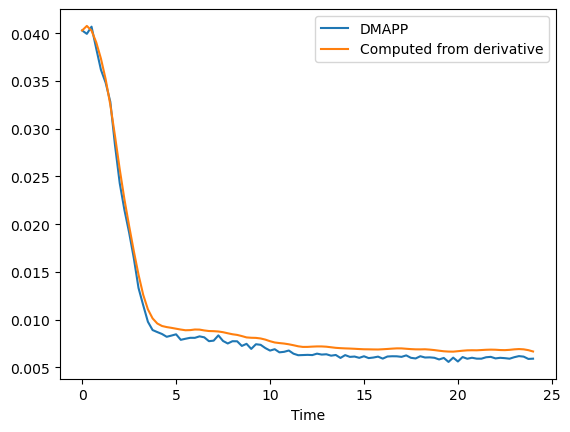

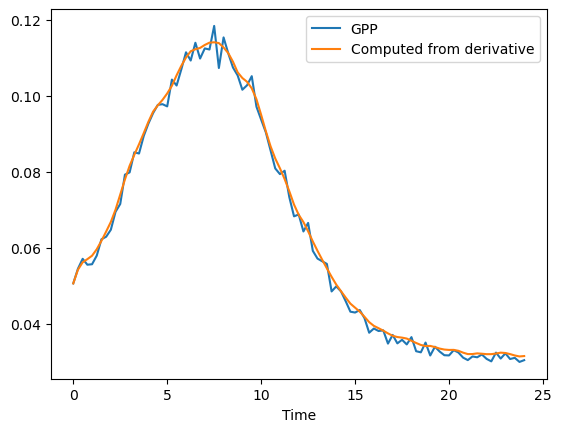

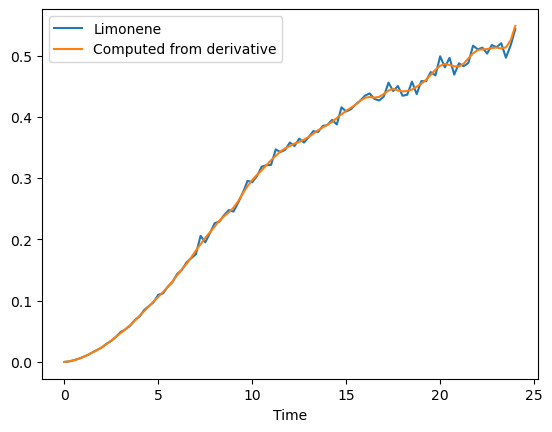

'Time profile from derivative vs. actual profile for Strain 3'

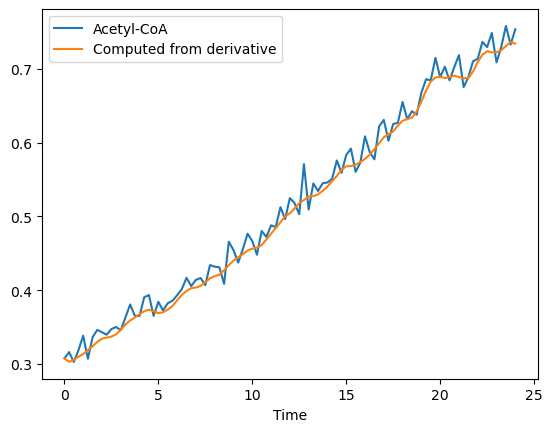

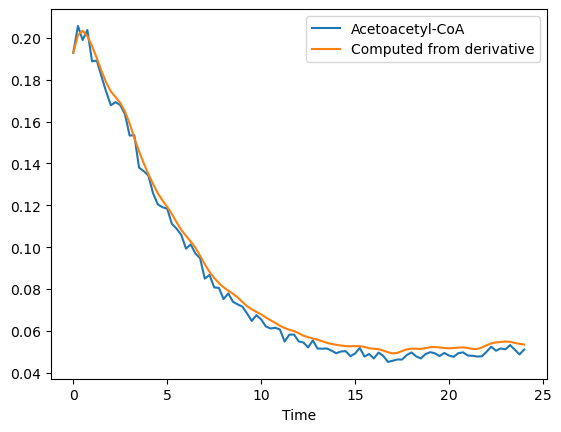

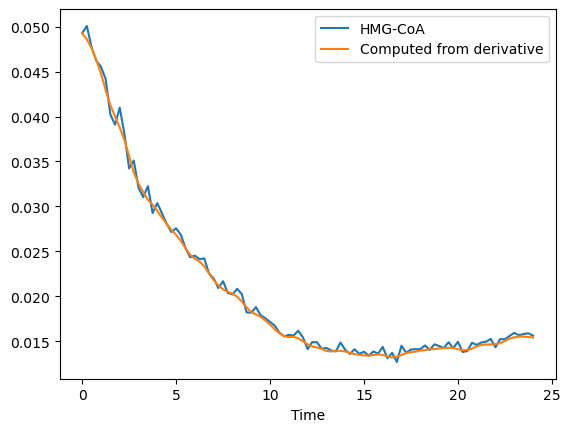

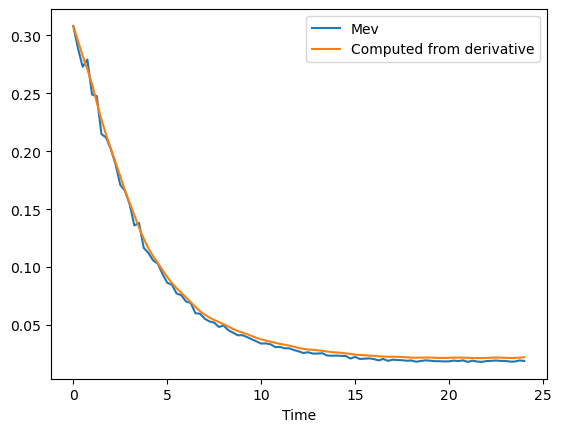

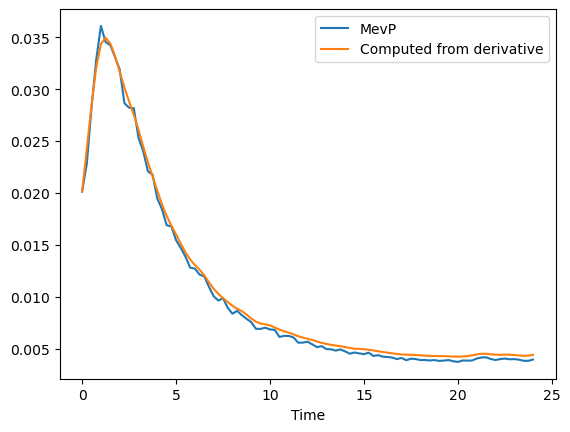

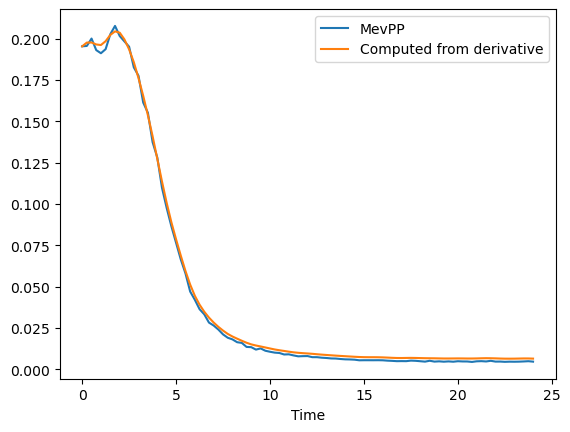

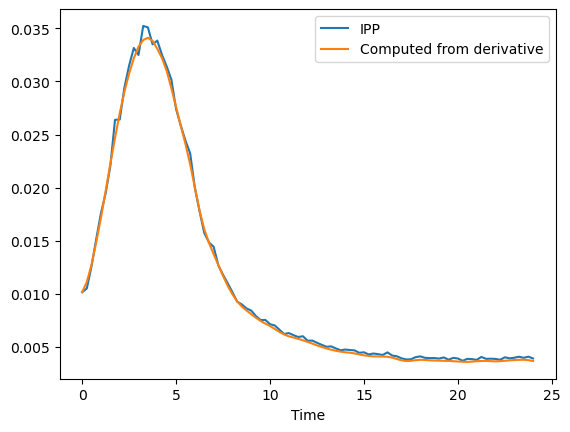

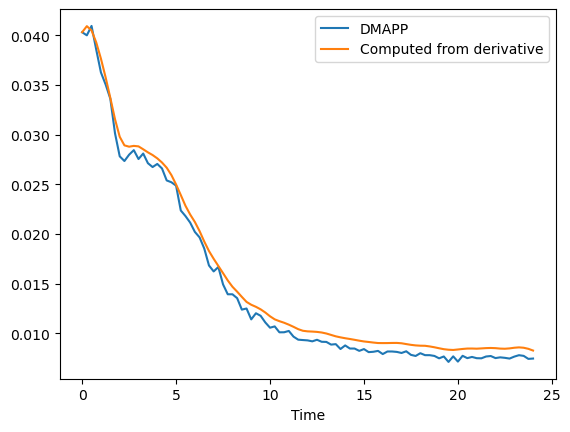

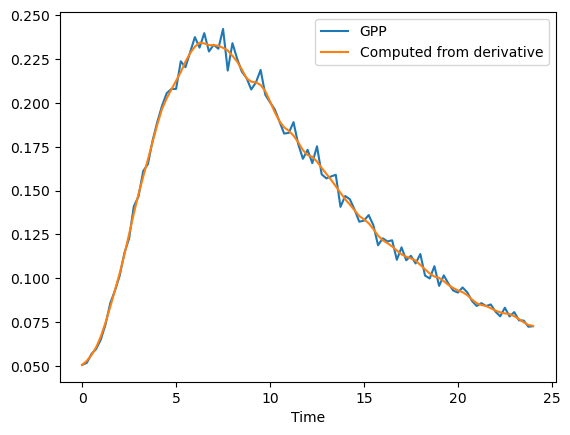

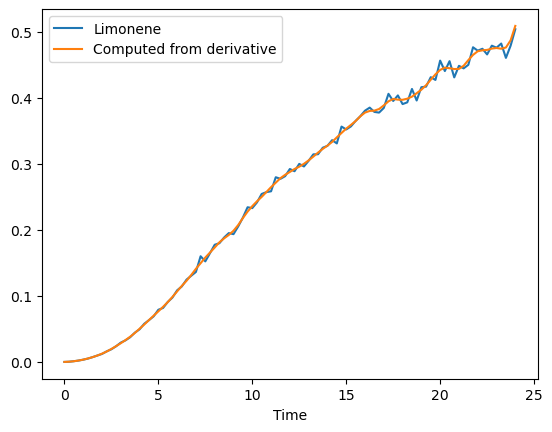

'Time profile from derivative vs. actual profile for WT'

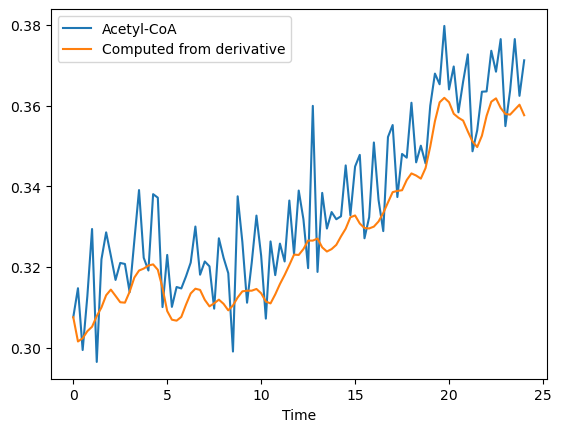

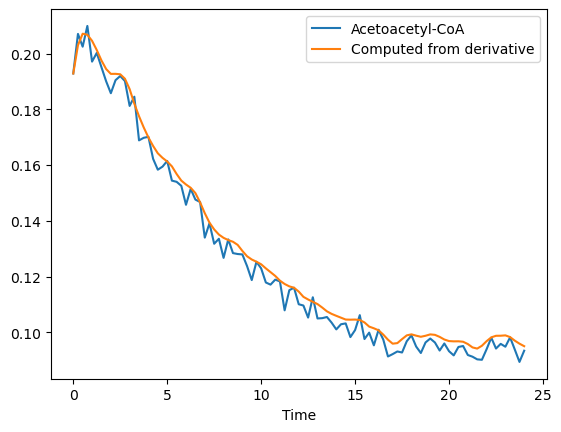

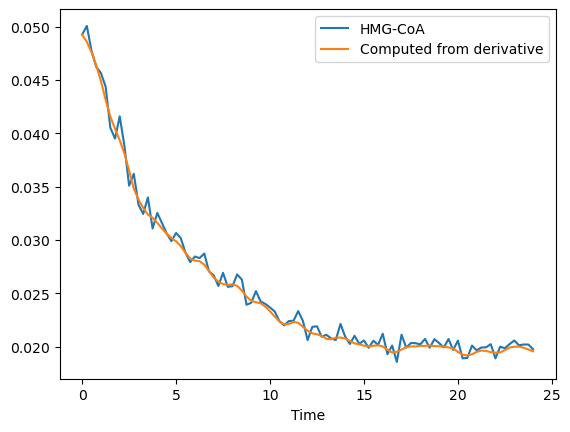

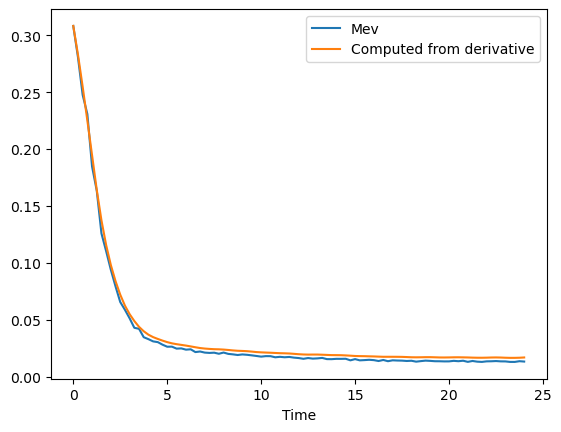

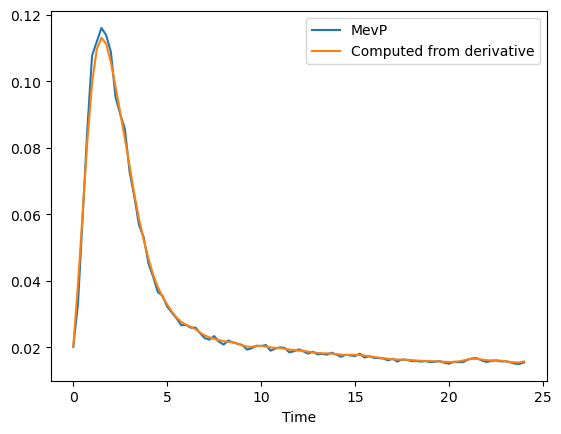

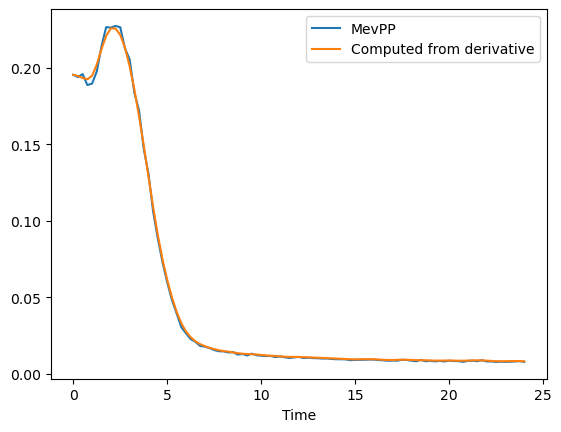

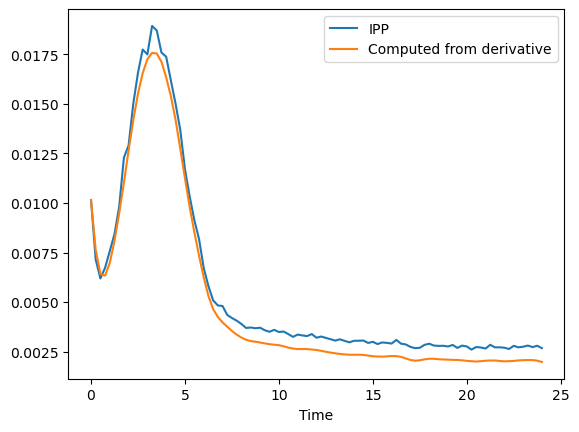

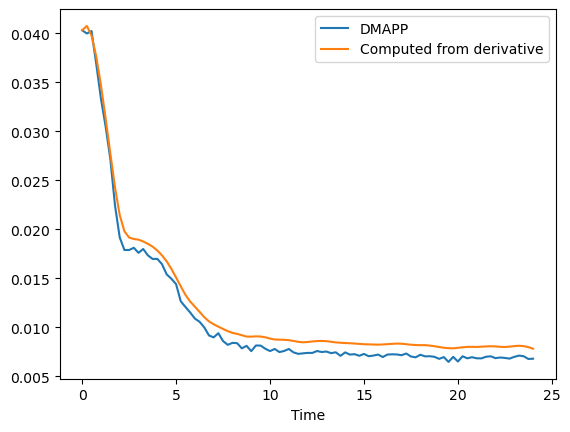

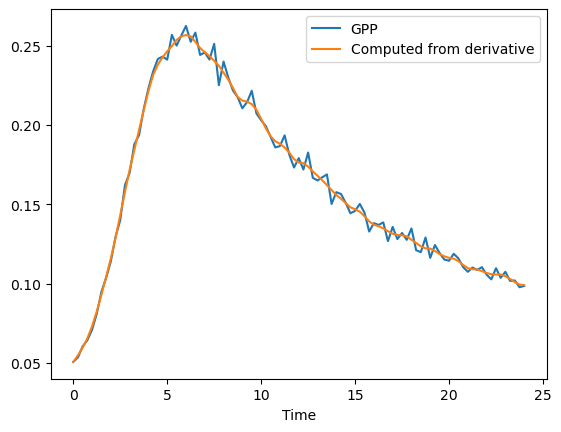

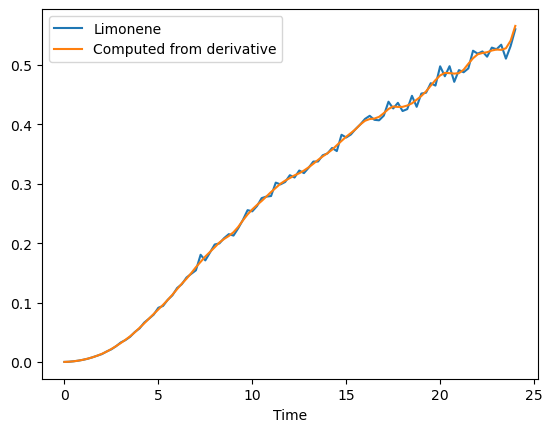

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   6.095775e+01  3.830916e+01  3.642460e+01  5.920951e+01   
         0.25   4.562280e+06  2.387218e+06  2.235850e+05  1.427086e+06   
         0.50   5.504432e+06  3.365541e+06  3.247253e+05  2.241663e+06   
         0.75   6.091505e+06  4.296528e+06  4.321469e+05  2.709233e+06   
         1.00   6.135963e+06  4.682593e+06  4.680041e+05  2.995600e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.798586e+06  2.781692e+06  1.783012e+06  2.035337e+06   
         23.25  2.728784e+06  2.650398e+06  1.720474e+06  2.059733e+06   
         23.50  2.660750e+06  2.644709e+06  1.715498e+06  2.021107e+06   
         23.75  2.849446e+06  2.810695e+06  1.740797e+06  2.018694e+06   
         24.00  2.896286e+06  2.699434e+06  1.767956e+06  2.029364e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.677443e+01  5.322851e+01  5.629791e+01  1.882676e+01   
         0.25   4.627639e+05  2.286100e+06  2.550127e+06  4.317176e+05   
         0.50   7.122424e+05  3.593802e+06  3.257557e+06  6.426762e+05   
         0.75   9.261810e+05  4.686807e+06  3.653431e+06  7.714662e+05   
         1.00   1.020998e+06  5.491013e+06  3.759702e+06  8.180992e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.536728e+06  4.151637e+06  4.284493e+06  1.165858e+06   
         23.25  1.471363e+06  3.997512e+06  4.218226e+06  1.274865e+06   
         23.50  1.436512e+06  3.889987e+06  4.419343e+06  1.271866e+06   
         23.75  1.486919e+06  3.867592e+06  4.201317e+06  1.255360e+06   
         24.00  1.501886e+06  3.974894e+06  4.319973e+06  1.191504e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.069984e+01   0.307507        0.192847  0.049264   
         0.25       1.833784e+05   0.308498        0.207747  0.054035   
         0.50       2.904854e+05   0.282681        0.202640  0.059937   
         0.75       3.394283e+05   0.282333        0.208303  0.068492   
         1.00       4.114768e+05   0.283047        0.193106  0.078973   
...                          ...        ...             ...       ...   
WT       23.00      1.457436e+06   0.354902        0.094860  0.020581   
         23.25      1.503237e+06   0.363674        0.098216  0.020132   
         23.50      1.553956e+06   0.376493        0.093859  0.020200   
         23.75      1.447999e+06   0.362412        0.089409  0.020199   
         24.00      1.515156e+06   0.371222        0.093427  0.019755   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.308261  0.020131  0.195401  0.010149  0.040297  0.050591   
         0.25   0.258928  0.053235  0.188805  0.011360  0.040084  0.054437   
         0.50   0.187190  0.111983  0.182363  0.014614  0.040182  0.067011   
         0.75   0.132268  0.156553  0.169426  0.017583  0.036275  0.079883   
         1.00   0.076945  0.177116  0.163251  0.020671  0.032536  0.097478   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.013272  0.015777  0.007760  0.002749  0.006996  0.107443   
         23.25  0.012835  0.015516  0.007826  0.002807  0.007125  0.101702   
         23.50  0.012826  0.015053  0.007997  0.002729  0.007060 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.058510        0.056914  0.013469 -0.241244  0.211782   
         0.25    -0.044272        0.028672  0.021509 -0.238480  0.189348   
         0.50    -0.030034        0.000430  0.029550 -0.235717  0.166914   
         0.75    -0.053172       -0.015574  0.034917 -0.211525  0.112225   
         1.00    -0.043182       -0.020460  0.032531 -0.159233  0.028170   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.001355        0.000656  0.000234 -0.000804 -0.000897   
         23.25   -0.002618       -0.005584 -0.000183 -0.000064 -0.000890   
         23.50    0.012551       -0.004669 -0.000634  0.000151 -0.000475   
         23.75   -0.002777       -0.003966 -0.000668  0.000658  0.000571   
         24.00   -0.018106       -0.003262 -0.000703  0.001164  0.001616   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.027011  0.006942  0.004903  0.015920  0.000071  
         0.25  -0.030241  0.008924 -0.001415  0.031804  0.000965  
         0.50  -0.033472  0.010907 -0.007733  0.047688  0.001860  
         0.75  -0.032231  0.012136 -0.010665  0.065499  0.002841  
         1.00  -0.028907  0.012110 -0.010773  0.084166  0.004056  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.000220 -0.000014  0.000262 -0.006946 -0.000693  
         23.25  0.000392  0.000056 -0.000004 -0.006922 -0.004265  
         23.50  0.000158 -0.000064 -0.000286 -0.008761  0.026076  
         23.75 -0.000426 -0.000187 -0.000524 -0.003893  0.075290  
         24.00 -0.001010 -0.000310 -0.000762  0.000976  0.124504  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem

# problem definition (object oriented to use population-based approach)
class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=34, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,-1.30103,0.0                         
                         ]), # lower bounds
                         xu=np.array([
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,-1.301029,9.0
                         ]) # upper bounds
                        )
        
    def _kinetic_model(self, e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                      s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                      k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
                      k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
                      k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
        #HC: 53 parameters (9+10+12+12+10)
        r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
        r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
        r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
        r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
        r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
        r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
        r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
        r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
        r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
        r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
        
        return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]
     
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [29]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [30]:
algo = 'ISRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e4)

In [31]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=10,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: ISRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  2.405893E+36 |  1.308632E+19
     2 |       74 |  3.144264E+18 |  4.694590E+14
     3 |      138 |  1.223748E+16 |  1.098244E+14
     4 |      202 |  1.267747E+15 |  1.838809E+13
     5 |      266 |  1.044491E+14 |  5.331710E+12
     6 |      330 |  4.329052E+13 |  1.130861E+11
     7 |      394 |  4.813493E+12 |  1.366509E+10
     8 |      458 |  6.879752E+11 |  1.366509E+10
     9 |      522 |  8.090369E+11 |  1.366509E+10
    10 |      586 |  3.382074E+11 |  4.445412E+09
    11 |      650 |  8.233194E+10 |  4.445412E+09
    12 |      714 |  2.309384E+10 |  1.230683E+09
    13 |      778 |  1.960175E+10 |  7.755579E+08
    14 |      842 |  6.875913E+09 |  2.897459E+08
    15 |      906 |  8.716795E+09 |  1.196823E+08
    16 |      970 |  8.300008E+08 |  1.801001E+07
    17 |     1034 |  9.576157E+07 |  4.641994E+06
    18 |     1098 |  6.763796E+07 |  2.864118E+06
    19 |     1162 |  2.62

   162 |    10314 |  2.880849E+01 |  2.456001E+01
   163 |    10378 |  2.906088E+01 |  2.456001E+01
   164 |    10442 |  2.844585E+01 |  2.456001E+01
   165 |    10506 |  2.844513E+01 |  2.456001E+01
   166 |    10570 |  2.815420E+01 |  2.456001E+01
   167 |    10634 |  2.790898E+01 |  2.456001E+01
   168 |    10698 |  2.707841E+01 |  2.456001E+01
   169 |    10762 |  2.858635E+01 |  2.456001E+01
   170 |    10826 |  2.791707E+01 |  2.456001E+01
   171 |    10890 |  2.819400E+01 |  2.456001E+01
   172 |    10954 |  2.787453E+01 |  2.456001E+01
   173 |    11018 |  2.853411E+01 |  2.456001E+01
   174 |    11082 |  2.778545E+01 |  2.456001E+01
   175 |    11146 |  2.699779E+01 |  2.456001E+01
   176 |    11210 |  2.675421E+01 |  2.423566E+01
   177 |    11274 |  2.757264E+01 |  2.423566E+01
   178 |    11338 |  2.766270E+01 |  2.423566E+01
   179 |    11402 |  2.818300E+01 |  2.423566E+01
   180 |    11466 |  2.763072E+01 |  2.423566E+01
   181 |    11530 |  2.791526E+01 |  2.423566E+01


   326 |    20810 |  1.470045E+01 |  1.438870E+01
   327 |    20874 |  1.472025E+01 |  1.438870E+01
   328 |    20938 |  1.470488E+01 |  1.438870E+01
   329 |    21002 |  1.462545E+01 |  1.438870E+01
   330 |    21066 |  1.464499E+01 |  1.438419E+01
   331 |    21130 |  1.466246E+01 |  1.438419E+01
   332 |    21194 |  1.459209E+01 |  1.436273E+01
   333 |    21258 |  1.446407E+01 |  1.395820E+01
   334 |    21322 |  1.439766E+01 |  1.395298E+01
   335 |    21386 |  1.421351E+01 |  1.395287E+01
   336 |    21450 |  1.418780E+01 |  1.395287E+01
   337 |    21514 |  1.405185E+01 |  1.395287E+01
   338 |    21578 |  1.401593E+01 |  1.391335E+01
   339 |    21642 |  1.394135E+01 |  1.383229E+01
   340 |    21706 |  1.391908E+01 |  1.378081E+01
   341 |    21770 |  1.389022E+01 |  1.374437E+01
   342 |    21834 |  1.391379E+01 |  1.374437E+01
   343 |    21898 |  1.387054E+01 |  1.374437E+01
   344 |    21962 |  1.390813E+01 |  1.374437E+01
   345 |    22026 |  1.391075E+01 |  1.373080E+01


   490 |    31306 |  1.156360E+01 |  1.151636E+01
   491 |    31370 |  1.154588E+01 |  1.147869E+01
   492 |    31434 |  1.153402E+01 |  1.147869E+01
   493 |    31498 |  1.151023E+01 |  1.147869E+01
   494 |    31562 |  1.148021E+01 |  1.141886E+01
   495 |    31626 |  1.144103E+01 |  1.132730E+01
   496 |    31690 |  1.138714E+01 |  1.127731E+01
   497 |    31754 |  1.132534E+01 |  1.126276E+01
   498 |    31818 |  1.129677E+01 |  1.125750E+01
   499 |    31882 |  1.129831E+01 |  1.125750E+01
   500 |    31946 |  1.128533E+01 |  1.125133E+01
   501 |    32010 |  1.122633E+01 |  1.118517E+01
   502 |    32074 |  1.118856E+01 |  1.109080E+01
   503 |    32138 |  1.116306E+01 |  1.107435E+01
   504 |    32202 |  1.112035E+01 |  1.107435E+01
   505 |    32266 |  1.108821E+01 |  1.104951E+01
   506 |    32330 |  1.103570E+01 |  1.098385E+01
   507 |    32394 |  1.102751E+01 |  1.098385E+01
   508 |    32458 |  1.101273E+01 |  1.096986E+01
   509 |    32522 |  1.097949E+01 |  1.094747E+01


   654 |    41802 |  1.037889E+01 |  1.037841E+01
   655 |    41866 |  1.037898E+01 |  1.037841E+01
   656 |    41930 |  1.037881E+01 |  1.037830E+01
   657 |    41994 |  1.037870E+01 |  1.037830E+01
   658 |    42058 |  1.037861E+01 |  1.037821E+01
   659 |    42122 |  1.037860E+01 |  1.037821E+01
   660 |    42186 |  1.037872E+01 |  1.037817E+01
   661 |    42250 |  1.037865E+01 |  1.037784E+01
   662 |    42314 |  1.037840E+01 |  1.037784E+01
   663 |    42378 |  1.037814E+01 |  1.037784E+01
   664 |    42442 |  1.037817E+01 |  1.037784E+01
   665 |    42506 |  1.037815E+01 |  1.037784E+01
   666 |    42570 |  1.037835E+01 |  1.037784E+01
   667 |    42634 |  1.037825E+01 |  1.037784E+01
   668 |    42698 |  1.037819E+01 |  1.037782E+01
   669 |    42762 |  1.037815E+01 |  1.037782E+01
   670 |    42826 |  1.037805E+01 |  1.037782E+01
   671 |    42890 |  1.037818E+01 |  1.037781E+01
   672 |    42954 |  1.037803E+01 |  1.037775E+01
   673 |    43018 |  1.037793E+01 |  1.037755E+01


   818 |    52298 |  9.7796479201 |  9.7756803014
   819 |    52362 |  9.7788929352 |  9.7756803014
   820 |    52426 |  9.7783621216 |  9.7756803014
   821 |    52490 |  9.7773077146 |  9.7744517843
   822 |    52554 |  9.7766032799 |  9.7728299473
   823 |    52618 |  9.7753128830 |  9.7728299473
   824 |    52682 |  9.7747366175 |  9.7728299473
   825 |    52746 |  9.7744175548 |  9.7728299473
   826 |    52810 |  9.7742698626 |  9.7728299473
   827 |    52874 |  9.7740652749 |  9.7728299473
   828 |    52938 |  9.7740657648 |  9.7728299473
   829 |    53002 |  9.7731983210 |  9.7723826178
   830 |    53066 |  9.7729577539 |  9.7716184743
   831 |    53130 |  9.7732008977 |  9.7716184743
   832 |    53194 |  9.7731982888 |  9.7716184743
   833 |    53258 |  9.7726426353 |  9.7716184743
   834 |    53322 |  9.7724329635 |  9.7716184743
   835 |    53386 |  9.7727119107 |  9.7706951960
   836 |    53450 |  9.7718785070 |  9.7706951960
   837 |    53514 |  9.7717319562 |  9.7706951960


   982 |    62794 |  9.7641444437 |  9.7640627000
   983 |    62858 |  9.7641293489 |  9.7640543786
   984 |    62922 |  9.7640983209 |  9.7640158540
   985 |    62986 |  9.7640906978 |  9.7639876440
   986 |    63050 |  9.7640707399 |  9.7639857862
   987 |    63114 |  9.7640447580 |  9.7639613511
   988 |    63178 |  9.7640387585 |  9.7639260175
   989 |    63242 |  9.7640052346 |  9.7639260175
   990 |    63306 |  9.7639921795 |  9.7639260175
   991 |    63370 |  9.7639825730 |  9.7639107031
   992 |    63434 |  9.7639561446 |  9.7638727552
   993 |    63498 |  9.7639456731 |  9.7638727552
   994 |    63562 |  9.7639163115 |  9.7638707622
   995 |    63626 |  9.7639010290 |  9.7638330038
   996 |    63690 |  9.7638627176 |  9.7638191456
   997 |    63754 |  9.7638659580 |  9.7638176299
   998 |    63818 |  9.7638672048 |  9.7638176299
   999 |    63882 |  9.7638603170 |  9.7637635240
  1000 |    63946 |  9.7638098488 |  9.7637635240
  1001 |    64010 |  9.7637869253 |  9.7637525450


  1146 |    73290 |  9.7503261193 |  9.7502737856
  1147 |    73354 |  9.7503016110 |  9.7502579590
  1148 |    73418 |  9.7502931161 |  9.7502579590
  1149 |    73482 |  9.7502897418 |  9.7502579590
  1150 |    73546 |  9.7502777919 |  9.7502470492
  1151 |    73610 |  9.7502611492 |  9.7502285233
  1152 |    73674 |  9.7502572481 |  9.7502283327
  1153 |    73738 |  9.7502521032 |  9.7502283327
  1154 |    73802 |  9.7502425242 |  9.7502260386
  1155 |    73866 |  9.7502444280 |  9.7502135091
  1156 |    73930 |  9.7502447473 |  9.7502113605
  1157 |    73994 |  9.7502469652 |  9.7502113605
  1158 |    74058 |  9.7502512991 |  9.7502113605
  1159 |    74122 |  9.7502419838 |  9.7502113605
  1160 |    74186 |  9.7502567773 |  9.7502113605
  1161 |    74250 |  9.7502492916 |  9.7502113605
  1162 |    74314 |  9.7502468455 |  9.7502113605
  1163 |    74378 |  9.7502238229 |  9.7501938800
  1164 |    74442 |  9.7502216965 |  9.7501938800
  1165 |    74506 |  9.7502178068 |  9.7501938800


  1310 |    83786 |  9.7429220506 |  9.7428712881
  1311 |    83850 |  9.7429203757 |  9.7428712881
  1312 |    83914 |  9.7429291557 |  9.7428712881
  1313 |    83978 |  9.7429314159 |  9.7428712881
  1314 |    84042 |  9.7429332231 |  9.7428712881
  1315 |    84106 |  9.7429238921 |  9.7428712881
  1316 |    84170 |  9.7429220286 |  9.7428712881
  1317 |    84234 |  9.7429150779 |  9.7428712881
  1318 |    84298 |  9.7429165739 |  9.7428650084
  1319 |    84362 |  9.7429148155 |  9.7428650084
  1320 |    84426 |  9.7429051485 |  9.7428650084
  1321 |    84490 |  9.7429034337 |  9.7428650084
  1322 |    84554 |  9.7428997452 |  9.7428650084
  1323 |    84618 |  9.7429091592 |  9.7428650084
  1324 |    84682 |  9.7429013623 |  9.7428643355
  1325 |    84746 |  9.7428843128 |  9.7428585445
  1326 |    84810 |  9.7428808674 |  9.7428585445
  1327 |    84874 |  9.7428718396 |  9.7428585445
  1328 |    84938 |  9.7428710079 |  9.7428446210
  1329 |    85002 |  9.7428657236 |  9.7428446210


  1474 |    94282 |  9.7425610377 |  9.7425598484
  1475 |    94346 |  9.7425609359 |  9.7425598484
  1476 |    94410 |  9.7425606000 |  9.7425595041
  1477 |    94474 |  9.7425602123 |  9.7425595041
  1478 |    94538 |  9.7425602908 |  9.7425593063
  1479 |    94602 |  9.7425604404 |  9.7425593063
  1480 |    94666 |  9.7425601150 |  9.7425592945
  1481 |    94730 |  9.7425596057 |  9.7425588944
  1482 |    94794 |  9.7425592081 |  9.7425584648
  1483 |    94858 |  9.7425587135 |  9.7425578192
  1484 |    94922 |  9.7425582822 |  9.7425573101
  1485 |    94986 |  9.7425574791 |  9.7425567033
  1486 |    95050 |  9.7425570399 |  9.7425565843
  1487 |    95114 |  9.7425571031 |  9.7425564248
  1488 |    95178 |  9.7425570364 |  9.7425564248
  1489 |    95242 |  9.7425567220 |  9.7425560392
  1490 |    95306 |  9.7425562929 |  9.7425553719
  1491 |    95370 |  9.7425558471 |  9.7425553719
  1492 |    95434 |  9.7425556215 |  9.7425543872
  1493 |    95498 |  9.7425558234 |  9.7425543872


  1638 |   104778 |  9.7424784537 |  9.7424775651
  1639 |   104842 |  9.7424780314 |  9.7424772560
  1640 |   104906 |  9.7424776351 |  9.7424769544
  1641 |   104970 |  9.7424779311 |  9.7424765696
  1642 |   105034 |  9.7424774850 |  9.7424755795
  1643 |   105098 |  9.7424764384 |  9.7424755795
  1644 |   105162 |  9.7424759461 |  9.7424750475
  1645 |   105226 |  9.7424760788 |  9.7424747562
  1646 |   105290 |  9.7424759025 |  9.7424747562
  1647 |   105354 |  9.7424754832 |  9.7424744910
  1648 |   105418 |  9.7424752973 |  9.7424734327
  1649 |   105482 |  9.7424750714 |  9.7424732489
  1650 |   105546 |  9.7424748345 |  9.7424732489
  1651 |   105610 |  9.7424738810 |  9.7424730628
  1652 |   105674 |  9.7424739295 |  9.7424725902
  1653 |   105738 |  9.7424733093 |  9.7424725061
  1654 |   105802 |  9.7424734267 |  9.7424723233
  1655 |   105866 |  9.7424726912 |  9.7424718130
  1656 |   105930 |  9.7424726165 |  9.7424699655
  1657 |   105994 |  9.7424715721 |  9.7424696526


  1802 |   115274 |  9.7424584149 |  9.7424583301
  1803 |   115338 |  9.7424584092 |  9.7424583301
  1804 |   115402 |  9.7424583769 |  9.7424583076
  1805 |   115466 |  9.7424583248 |  9.7424582328
  1806 |   115530 |  9.7424582882 |  9.7424582328
  1807 |   115594 |  9.7424582552 |  9.7424581949
  1808 |   115658 |  9.7424582309 |  9.7424581927
  1809 |   115722 |  9.7424582340 |  9.7424581927
  1810 |   115786 |  9.7424582336 |  9.7424581654
  1811 |   115850 |  9.7424582294 |  9.7424581654
  1812 |   115914 |  9.7424582073 |  9.7424581654
  1813 |   115978 |  9.7424582381 |  9.7424581654
  1814 |   116042 |  9.7424581995 |  9.7424581589
  1815 |   116106 |  9.7424581719 |  9.7424581121
  1816 |   116170 |  9.7424581471 |  9.7424581055
  1817 |   116234 |  9.7424581310 |  9.7424580930
  1818 |   116298 |  9.7424581128 |  9.7424580843
  1819 |   116362 |  9.7424581168 |  9.7424580808
  1820 |   116426 |  9.7424580979 |  9.7424580676
  1821 |   116490 |  9.7424580939 |  9.7424580184


  1966 |   125770 |  9.7424493011 |  9.7424490350
  1967 |   125834 |  9.7424493376 |  9.7424490350
  1968 |   125898 |  9.7424493236 |  9.7424490350
  1969 |   125962 |  9.7424493529 |  9.7424490350
  1970 |   126026 |  9.7424492652 |  9.7424490350
  1971 |   126090 |  9.7424492496 |  9.7424490017
  1972 |   126154 |  9.7424491750 |  9.7424490017
  1973 |   126218 |  9.7424491484 |  9.7424490017
  1974 |   126282 |  9.7424491240 |  9.7424489944
  1975 |   126346 |  9.7424490716 |  9.7424489857
  1976 |   126410 |  9.7424489830 |  9.7424489474
  1977 |   126474 |  9.7424489940 |  9.7424489110
  1978 |   126538 |  9.7424489796 |  9.7424489110
  1979 |   126602 |  9.7424489536 |  9.7424488474
  1980 |   126666 |  9.7424489172 |  9.7424488451
  1981 |   126730 |  9.7424489023 |  9.7424488451
  1982 |   126794 |  9.7424488631 |  9.7424487669
  1983 |   126858 |  9.7424488418 |  9.7424487326
  1984 |   126922 |  9.7424487798 |  9.7424487283
  1985 |   126986 |  9.7424487657 |  9.7424487181


  2130 |   136266 |  9.7424478847 |  9.7424478674
  2131 |   136330 |  9.7424478767 |  9.7424478585
  2132 |   136394 |  9.7424478795 |  9.7424478585
  2133 |   136458 |  9.7424478762 |  9.7424478585
  2134 |   136522 |  9.7424478719 |  9.7424478585
  2135 |   136586 |  9.7424478684 |  9.7424478553
  2136 |   136650 |  9.7424478662 |  9.7424478501
  2137 |   136714 |  9.7424478636 |  9.7424478474
  2138 |   136778 |  9.7424478609 |  9.7424478474
  2139 |   136842 |  9.7424478600 |  9.7424478305
  2140 |   136906 |  9.7424478489 |  9.7424478305
  2141 |   136970 |  9.7424478452 |  9.7424478305
  2142 |   137034 |  9.7424478395 |  9.7424478300
  2143 |   137098 |  9.7424478377 |  9.7424478300
  2144 |   137162 |  9.7424478405 |  9.7424478300
  2145 |   137226 |  9.7424478446 |  9.7424478300
  2146 |   137290 |  9.7424478426 |  9.7424478300
  2147 |   137354 |  9.7424478431 |  9.7424478300
  2148 |   137418 |  9.7424478372 |  9.7424478300
  2149 |   137482 |  9.7424478366 |  9.7424478254


  2294 |   146762 |  9.7289424404 |  9.7288970858
  2295 |   146826 |  9.7289230745 |  9.7288970858
  2296 |   146890 |  9.7289169787 |  9.7288930366
  2297 |   146954 |  9.7288976701 |  9.7288836361
  2298 |   147018 |  9.7288909440 |  9.7288645085
  2299 |   147082 |  9.7288808455 |  9.7288645085
  2300 |   147146 |  9.7288751931 |  9.7288568721
  2301 |   147210 |  9.7288602645 |  9.7288467716
  2302 |   147274 |  9.7288578873 |  9.7288467716
  2303 |   147338 |  9.7288506148 |  9.7288381891
  2304 |   147402 |  9.7288454654 |  9.7288381891
  2305 |   147466 |  9.7288396526 |  9.7288274426
  2306 |   147530 |  9.7288327970 |  9.7288239955
  2307 |   147594 |  9.7288263275 |  9.7288116739
  2308 |   147658 |  9.7288157512 |  9.7287912472
  2309 |   147722 |  9.7288072153 |  9.7287912472
  2310 |   147786 |  9.7287996529 |  9.7287847789
  2311 |   147850 |  9.7287916748 |  9.7287786863
  2312 |   147914 |  9.7287705568 |  9.7287134675
  2313 |   147978 |  9.7287299898 |  9.7287039535


  2458 |   157258 |  9.7201213591 |  9.7200944514
  2459 |   157322 |  9.7201119637 |  9.7200710420
  2460 |   157386 |  9.7200851203 |  9.7200613589
  2461 |   157450 |  9.7200739718 |  9.7200555384
  2462 |   157514 |  9.7200675959 |  9.7200454438
  2463 |   157578 |  9.7200550351 |  9.7200400912
  2464 |   157642 |  9.7200389395 |  9.7200020167
  2465 |   157706 |  9.7200142701 |  9.7199731406
  2466 |   157770 |  9.7200093101 |  9.7199731406
  2467 |   157834 |  9.7199989286 |  9.7199627144
  2468 |   157898 |  9.7199767262 |  9.7199439987
  2469 |   157962 |  9.7199664138 |  9.7199294558
  2470 |   158026 |  9.7199486030 |  9.7199105149
  2471 |   158090 |  9.7199524231 |  9.7199105149
  2472 |   158154 |  9.7199550849 |  9.7199105149
  2473 |   158218 |  9.7199434846 |  9.7199028364
  2474 |   158282 |  9.7199330164 |  9.7198872678
  2475 |   158346 |  9.7199353595 |  9.7198872678
  2476 |   158410 |  9.7199216656 |  9.7198872678
  2477 |   158474 |  9.7199347989 |  9.7198872678


  2622 |   167754 |  9.7194186109 |  9.7194158791
  2623 |   167818 |  9.7194175787 |  9.7194158791
  2624 |   167882 |  9.7194159578 |  9.7194135481
  2625 |   167946 |  9.7194140534 |  9.7194119518
  2626 |   168010 |  9.7194123634 |  9.7194103866
  2627 |   168074 |  9.7194109251 |  9.7194094154
  2628 |   168138 |  9.7194102206 |  9.7194090376
  2629 |   168202 |  9.7194090315 |  9.7194082165
  2630 |   168266 |  9.7194078129 |  9.7194048717
  2631 |   168330 |  9.7194065871 |  9.7194037127
  2632 |   168394 |  9.7194050104 |  9.7194035091
  2633 |   168458 |  9.7194043441 |  9.7194024755
  2634 |   168522 |  9.7194048913 |  9.7194011833
  2635 |   168586 |  9.7194022848 |  9.7193988273
  2636 |   168650 |  9.7193998798 |  9.7193983170
  2637 |   168714 |  9.7193986052 |  9.7193941944
  2638 |   168778 |  9.7193948105 |  9.7193905240
  2639 |   168842 |  9.7193909646 |  9.7193883324
  2640 |   168906 |  9.7193893796 |  9.7193876979
  2641 |   168970 |  9.7193847626 |  9.7193766077


  2786 |   178250 |  9.7190834455 |  9.7190819197
  2787 |   178314 |  9.7190829110 |  9.7190814396
  2788 |   178378 |  9.7190826990 |  9.7190814396
  2789 |   178442 |  9.7190827086 |  9.7190814396
  2790 |   178506 |  9.7190822401 |  9.7190810093
  2791 |   178570 |  9.7190814306 |  9.7190797637
  2792 |   178634 |  9.7190810574 |  9.7190797637
  2793 |   178698 |  9.7190806586 |  9.7190790304
  2794 |   178762 |  9.7190799705 |  9.7190790304
  2795 |   178826 |  9.7190796676 |  9.7190780153
  2796 |   178890 |  9.7190789171 |  9.7190779391
  2797 |   178954 |  9.7190782531 |  9.7190766919
  2798 |   179018 |  9.7190776488 |  9.7190765606
  2799 |   179082 |  9.7190771273 |  9.7190748025
  2800 |   179146 |  9.7190756627 |  9.7190734426
  2801 |   179210 |  9.7190745713 |  9.7190732916
  2802 |   179274 |  9.7190739760 |  9.7190729320
  2803 |   179338 |  9.7190736991 |  9.7190724281
  2804 |   179402 |  9.7190734548 |  9.7190724281
  2805 |   179466 |  9.7190735723 |  9.7190724281


  2950 |   188746 |  9.7189156701 |  9.7189099324
  2951 |   188810 |  9.7189145782 |  9.7189099324
  2952 |   188874 |  9.7189129235 |  9.7189092649
  2953 |   188938 |  9.7189123525 |  9.7189080346
  2954 |   189002 |  9.7189114050 |  9.7189075674
  2955 |   189066 |  9.7189111097 |  9.7189075674
  2956 |   189130 |  9.7189115538 |  9.7189075674
  2957 |   189194 |  9.7189124904 |  9.7189075674
  2958 |   189258 |  9.7189113079 |  9.7189075674
  2959 |   189322 |  9.7189115038 |  9.7189075674
  2960 |   189386 |  9.7189110038 |  9.7189048850
  2961 |   189450 |  9.7189131209 |  9.7189048850
  2962 |   189514 |  9.7189120578 |  9.7189048850
  2963 |   189578 |  9.7189090885 |  9.7189037972
  2964 |   189642 |  9.7189057769 |  9.7189015790
  2965 |   189706 |  9.7189049041 |  9.7189015790
  2966 |   189770 |  9.7189056420 |  9.7189007525
  2967 |   189834 |  9.7189041813 |  9.7189007525
  2968 |   189898 |  9.7189035230 |  9.7189005510
  2969 |   189962 |  9.7189026780 |  9.7189005510


  3114 |   199242 |  9.7188725975 |  9.7188724394
  3115 |   199306 |  9.7188725124 |  9.7188723226
  3116 |   199370 |  9.7188723849 |  9.7188721723
  3117 |   199434 |  9.7188724793 |  9.7188721723
  3118 |   199498 |  9.7188722409 |  9.7188719262
  3119 |   199562 |  9.7188722314 |  9.7188719262
  3120 |   199626 |  9.7188721273 |  9.7188717087
  3121 |   199690 |  9.7188720878 |  9.7188717087
  3122 |   199754 |  9.7188720094 |  9.7188717087
  3123 |   199818 |  9.7188719510 |  9.7188716309
  3124 |   199882 |  9.7188719052 |  9.7188715487
  3125 |   199946 |  9.7188717781 |  9.7188713550
  3126 |   200010 |  9.7188715585 |  9.7188711954
  3127 |   200074 |  9.7188715477 |  9.7188711954
  3128 |   200138 |  9.7188715192 |  9.7188711954
  3129 |   200202 |  9.7188715553 |  9.7188711954
  3130 |   200266 |  9.7188714527 |  9.7188711482
  3131 |   200330 |  9.7188714441 |  9.7188711482
  3132 |   200394 |  9.7188713232 |  9.7188709305
  3133 |   200458 |  9.7188710857 |  9.7188708361


  3278 |   209738 |  9.7188681626 |  9.7188681489
  3279 |   209802 |  9.7188681497 |  9.7188681402
  3280 |   209866 |  9.7188681335 |  9.7188681128
  3281 |   209930 |  9.7188681263 |  9.7188681128
  3282 |   209994 |  9.7188681248 |  9.7188681128
  3283 |   210058 |  9.7188681242 |  9.7188681128
  3284 |   210122 |  9.7188681158 |  9.7188681088
  3285 |   210186 |  9.7188681053 |  9.7188680769
  3286 |   210250 |  9.7188680957 |  9.7188680769
  3287 |   210314 |  9.7188680922 |  9.7188680692
  3288 |   210378 |  9.7188680832 |  9.7188680692
  3289 |   210442 |  9.7188680714 |  9.7188680545
  3290 |   210506 |  9.7188680566 |  9.7188680448
  3291 |   210570 |  9.7188680527 |  9.7188680420
  3292 |   210634 |  9.7188680443 |  9.7188680198
  3293 |   210698 |  9.7188680341 |  9.7188680120
  3294 |   210762 |  9.7188680233 |  9.7188679998
  3295 |   210826 |  9.7188680070 |  9.7188679625
  3296 |   210890 |  9.7188679741 |  9.7188679530
  3297 |   210954 |  9.7188679647 |  9.7188679505


  3442 |   220234 |  9.7188673964 |  9.7188673903
  3443 |   220298 |  9.7188673960 |  9.7188673873
  3444 |   220362 |  9.7188673913 |  9.7188673851
  3445 |   220426 |  9.7188673901 |  9.7188673812
  3446 |   220490 |  9.7188673884 |  9.7188673812
  3447 |   220554 |  9.7188673860 |  9.7188673812
  3448 |   220618 |  9.7188673854 |  9.7188673794
  3449 |   220682 |  9.7188673846 |  9.7188673794
  3450 |   220746 |  9.7188673817 |  9.7188673794
  3451 |   220810 |  9.7188673791 |  9.7188673720
  3452 |   220874 |  9.7188673752 |  9.7188673720
  3453 |   220938 |  9.7188673760 |  9.7188673676
  3454 |   221002 |  9.7188673722 |  9.7188673676
  3455 |   221066 |  9.7188673713 |  9.7188673676
  3456 |   221130 |  9.7188673719 |  9.7188673676
  3457 |   221194 |  9.7188673707 |  9.7188673667
  3458 |   221258 |  9.7188673708 |  9.7188673667
  3459 |   221322 |  9.7188673707 |  9.7188673667
  3460 |   221386 |  9.7188673686 |  9.7188673662
  3461 |   221450 |  9.7188673687 |  9.7188673662


  3606 |   230730 |  9.7188673295 |  9.7188673293
  3607 |   230794 |  9.7188673295 |  9.7188673293
  3608 |   230858 |  9.7188673294 |  9.7188673293
  3609 |   230922 |  9.7188673294 |  9.7188673293
  3610 |   230986 |  9.7188673294 |  9.7188673293
  3611 |   231050 |  9.7188673294 |  9.7188673293
  3612 |   231114 |  9.7188673294 |  9.7188673291
  3613 |   231178 |  9.7188673293 |  9.7188673291
  3614 |   231242 |  9.7188673293 |  9.7188673291
  3615 |   231306 |  9.7188673293 |  9.7188673291
  3616 |   231370 |  9.7188673292 |  9.7188673291
  3617 |   231434 |  9.7188673292 |  9.7188673291
  3618 |   231498 |  9.7188673292 |  9.7188673291
  3619 |   231562 |  9.7188673292 |  9.7188673291
  3620 |   231626 |  9.7188673292 |  9.7188673291
  3621 |   231690 |  9.7188673292 |  9.7188673291
  3622 |   231754 |  9.7188673292 |  9.7188673291
  3623 |   231818 |  9.7188673291 |  9.7188673291
  3624 |   231882 |  9.7188673292 |  9.7188673291
  3625 |   231946 |  9.7188673292 |  9.7188673291


  3770 |   241226 |  9.7188673233 |  9.7188673233
  3771 |   241290 |  9.7188673233 |  9.7188673233
  3772 |   241354 |  9.7188673233 |  9.7188673233
  3773 |   241418 |  9.7188673233 |  9.7188673233
  3774 |   241482 |  9.7188673233 |  9.7188673233
  3775 |   241546 |  9.7188673233 |  9.7188673233
  3776 |   241610 |  9.7188673233 |  9.7188673233
  3777 |   241674 |  9.7188673233 |  9.7188673233
  3778 |   241738 |  9.7188673233 |  9.7188673233
  3779 |   241802 |  9.7188673233 |  9.7188673233
  3780 |   241866 |  9.7188673233 |  9.7188673233
  3781 |   241930 |  9.7188673233 |  9.7188673233
  3782 |   241994 |  9.7188673233 |  9.7188673233
  3783 |   242058 |  9.7188673233 |  9.7188673232
  3784 |   242122 |  9.7188673233 |  9.7188673232
  3785 |   242186 |  9.7188673232 |  9.7188673232
  3786 |   242250 |  9.7188673232 |  9.7188673232
  3787 |   242314 |  9.7188673232 |  9.7188673232
  3788 |   242378 |  9.7188673232 |  9.7188673232
  3789 |   242442 |  9.7188673232 |  9.7188673232


  3934 |   251722 |  9.7188673230 |  9.7188673230
  3935 |   251786 |  9.7188673230 |  9.7188673230
  3936 |   251850 |  9.7188673230 |  9.7188673230
  3937 |   251914 |  9.7188673230 |  9.7188673230
  3938 |   251978 |  9.7188673230 |  9.7188673230
  3939 |   252042 |  9.7188673230 |  9.7188673230
  3940 |   252106 |  9.7188673230 |  9.7188673230
  3941 |   252170 |  9.7188673230 |  9.7188673230
  3942 |   252234 |  9.7188673230 |  9.7188673230
  3943 |   252298 |  9.7188673230 |  9.7188673230
  3944 |   252362 |  9.7188673230 |  9.7188673230
  3945 |   252426 |  9.7188673230 |  9.7188673230
  3946 |   252490 |  9.7188673230 |  9.7188673230
  3947 |   252554 |  9.7188673230 |  9.7188673230
  3948 |   252618 |  9.7188673230 |  9.7188673230
  3949 |   252682 |  9.7188673230 |  9.7188673230
  3950 |   252746 |  9.7188673230 |  9.7188673230
  3951 |   252810 |  9.7188673230 |  9.7188673230
  3952 |   252874 |  9.7188673230 |  9.7188673230
  3953 |   252938 |  9.7188673230 |  9.7188673230


  4098 |   262218 |  9.7188673230 |  9.7188673230
  4099 |   262282 |  9.7188673230 |  9.7188673230
  4100 |   262346 |  9.7188673230 |  9.7188673230
  4101 |   262410 |  9.7188673230 |  9.7188673230
  4102 |   262474 |  9.7188673230 |  9.7188673230
  4103 |   262538 |  9.7188673230 |  9.7188673230
  4104 |   262602 |  9.7188673230 |  9.7188673230
  4105 |   262666 |  9.7188673230 |  9.7188673230
  4106 |   262730 |  9.7188673230 |  9.7188673230
  4107 |   262794 |  9.7188673230 |  9.7188673230
  4108 |   262858 |  9.7188673230 |  9.7188673230
  4109 |   262922 |  9.7188673230 |  9.7188673230
  4110 |   262986 |  9.7188673230 |  9.7188673230
  4111 |   263050 |  9.7188673230 |  9.7188673230
  4112 |   263114 |  9.7188673230 |  9.7188673230
  4113 |   263178 |  9.7188673230 |  9.7188673230
  4114 |   263242 |  9.7188673230 |  9.7188673230
  4115 |   263306 |  9.7188673230 |  9.7188673230
  4116 |   263370 |  9.7188673230 |  9.7188673230
  4117 |   263434 |  9.7188673230 |  9.7188673230


  4262 |   272714 |  9.7188673229 |  9.7188673229
  4263 |   272778 |  9.7188673229 |  9.7188673229
  4264 |   272842 |  9.7188673229 |  9.7188673229
  4265 |   272906 |  9.7188673229 |  9.7188673229
  4266 |   272970 |  9.7188673229 |  9.7188673229
  4267 |   273034 |  9.7188673229 |  9.7188673229
  4268 |   273098 |  9.7188673229 |  9.7188673229
  4269 |   273162 |  9.7188673229 |  9.7188673229
  4270 |   273226 |  9.7188673229 |  9.7188673229
  4271 |   273290 |  9.7188673229 |  9.7188673229
  4272 |   273354 |  9.7188673229 |  9.7188673229
  4273 |   273418 |  9.7188673229 |  9.7188673229
  4274 |   273482 |  9.7188673229 |  9.7188673229
  4275 |   273546 |  9.7188673229 |  9.7188673229
  4276 |   273610 |  9.7188673229 |  9.7188673229
  4277 |   273674 |  9.7188673229 |  9.7188673229
  4278 |   273738 |  9.7188673229 |  9.7188673229
  4279 |   273802 |  9.7188673229 |  9.7188673229
  4280 |   273866 |  9.7188673229 |  9.7188673229
  4281 |   273930 |  9.7188673229 |  9.7188673229


  4426 |   283210 |  9.7188673229 |  9.7188673229
  4427 |   283274 |  9.7188673229 |  9.7188673229
  4428 |   283338 |  9.7188673229 |  9.7188673229
  4429 |   283402 |  9.7188673229 |  9.7188673229
  4430 |   283466 |  9.7188673229 |  9.7188673229
  4431 |   283530 |  9.7188673229 |  9.7188673229
  4432 |   283594 |  9.7188673229 |  9.7188673229
  4433 |   283658 |  9.7188673229 |  9.7188673229
  4434 |   283722 |  9.7188673229 |  9.7188673229
  4435 |   283786 |  9.7188673229 |  9.7188673229
  4436 |   283850 |  9.7188673229 |  9.7188673229
  4437 |   283914 |  9.7188673229 |  9.7188673229
  4438 |   283978 |  9.7188673229 |  9.7188673229
  4439 |   284042 |  9.7188673229 |  9.7188673229
  4440 |   284106 |  9.7188673229 |  9.7188673229
  4441 |   284170 |  9.7188673229 |  9.7188673229
  4442 |   284234 |  9.7188673229 |  9.7188673229
  4443 |   284298 |  9.7188673229 |  9.7188673229
  4444 |   284362 |  9.7188673229 |  9.7188673229
  4445 |   284426 |  9.7188673229 |  9.7188673229


  4590 |   293706 |  9.7188673229 |  9.7188673229
  4591 |   293770 |  9.7188673229 |  9.7188673229
  4592 |   293834 |  9.7188673229 |  9.7188673229
  4593 |   293898 |  9.7188673229 |  9.7188673229
  4594 |   293962 |  9.7188673229 |  9.7188673229
  4595 |   294026 |  9.7188673229 |  9.7188673229
  4596 |   294090 |  9.7188673229 |  9.7188673229
  4597 |   294154 |  9.7188673229 |  9.7188673229
  4598 |   294218 |  9.7188673229 |  9.7188673229
  4599 |   294282 |  9.7188673229 |  9.7188673229
  4600 |   294346 |  9.7188673229 |  9.7188673229
  4601 |   294410 |  9.7188673229 |  9.7188673229
  4602 |   294474 |  9.7188673229 |  9.7188673229
  4603 |   294538 |  9.7188673229 |  9.7188673229
  4604 |   294602 |  9.7188673229 |  9.7188673229
  4605 |   294666 |  9.7188673229 |  9.7188673229
  4606 |   294730 |  9.7188673229 |  9.7188673229
  4607 |   294794 |  9.7188673229 |  9.7188673229
  4608 |   294858 |  9.7188673229 |  9.7188673229
  4609 |   294922 |  9.7188673229 |  9.7188673229


  4754 |   304202 |  9.7188673229 |  9.7188673229
  4755 |   304266 |  9.7188673229 |  9.7188673229
  4756 |   304330 |  9.7188673229 |  9.7188673229
  4757 |   304394 |  9.7188673229 |  9.7188673229
  4758 |   304458 |  9.7188673229 |  9.7188673229
  4759 |   304522 |  9.7188673229 |  9.7188673229
  4760 |   304586 |  9.7188673229 |  9.7188673229
  4761 |   304650 |  9.7188673229 |  9.7188673229
  4762 |   304714 |  9.7188673229 |  9.7188673229
  4763 |   304778 |  9.7188673229 |  9.7188673229
  4764 |   304842 |  9.7188673229 |  9.7188673229
  4765 |   304906 |  9.7188673229 |  9.7188673229
  4766 |   304970 |  9.7188673229 |  9.7188673229
  4767 |   305034 |  9.7188673229 |  9.7188673229
  4768 |   305098 |  9.7188673229 |  9.7188673229
  4769 |   305162 |  9.7188673229 |  9.7188673229
  4770 |   305226 |  9.7188673229 |  9.7188673229
  4771 |   305290 |  9.7188673229 |  9.7188673229
  4772 |   305354 |  9.7188673229 |  9.7188673229
  4773 |   305418 |  9.7188673229 |  9.7188673229


  4918 |   314698 |  9.7188673229 |  9.7188673229
  4919 |   314762 |  9.7188673229 |  9.7188673229
  4920 |   314826 |  9.7188673229 |  9.7188673229
  4921 |   314890 |  9.7188673229 |  9.7188673229
  4922 |   314954 |  9.7188673229 |  9.7188673229
  4923 |   315018 |  9.7188673229 |  9.7188673229
  4924 |   315082 |  9.7188673229 |  9.7188673229
  4925 |   315146 |  9.7188673229 |  9.7188673229
  4926 |   315210 |  9.7188673229 |  9.7188673229
  4927 |   315274 |  9.7188673229 |  9.7188673229
  4928 |   315338 |  9.7188673229 |  9.7188673229
  4929 |   315402 |  9.7188673229 |  9.7188673229
  4930 |   315466 |  9.7188673229 |  9.7188673229
  4931 |   315530 |  9.7188673229 |  9.7188673229
  4932 |   315594 |  9.7188673229 |  9.7188673229
  4933 |   315658 |  9.7188673229 |  9.7188673229
  4934 |   315722 |  9.7188673229 |  9.7188673229
  4935 |   315786 |  9.7188673229 |  9.7188673229
  4936 |   315850 |  9.7188673229 |  9.7188673229
  4937 |   315914 |  9.7188673229 |  9.7188673229


  5082 |   325194 |  9.7188673229 |  9.7188673229
  5083 |   325258 |  9.7188673229 |  9.7188673229
  5084 |   325322 |  9.7188673229 |  9.7188673229
  5085 |   325386 |  9.7188673229 |  9.7188673229
  5086 |   325450 |  9.7188673229 |  9.7188673229
  5087 |   325514 |  9.7188673229 |  9.7188673229
  5088 |   325578 |  9.7188673229 |  9.7188673229
  5089 |   325642 |  9.7188673229 |  9.7188673229
  5090 |   325706 |  9.7188673229 |  9.7188673229
  5091 |   325770 |  9.7188673229 |  9.7188673229
  5092 |   325834 |  9.7188673229 |  9.7188673229
  5093 |   325898 |  9.7188673229 |  9.7188673229
  5094 |   325962 |  9.7188673229 |  9.7188673229
  5095 |   326026 |  9.7188673229 |  9.7188673229
  5096 |   326090 |  9.7188673229 |  9.7188673229
  5097 |   326154 |  9.7188673229 |  9.7188673229
  5098 |   326218 |  9.7188673229 |  9.7188673229
  5099 |   326282 |  9.7188673229 |  9.7188673229
  5100 |   326346 |  9.7188673229 |  9.7188673229
  5101 |   326410 |  9.7188673229 |  9.7188673229


  5246 |   335690 |  9.7188673229 |  9.7188673229
  5247 |   335754 |  9.7188673229 |  9.7188673229
  5248 |   335818 |  9.7188673229 |  9.7188673229
  5249 |   335882 |  9.7188673229 |  9.7188673229
  5250 |   335946 |  9.7188673229 |  9.7188673229
  5251 |   336010 |  9.7188673229 |  9.7188673229
  5252 |   336074 |  9.7188673229 |  9.7188673229
  5253 |   336138 |  9.7188673229 |  9.7188673229
  5254 |   336202 |  9.7188673229 |  9.7188673229
  5255 |   336266 |  9.7188673229 |  9.7188673229
  5256 |   336330 |  9.7188673229 |  9.7188673229
  5257 |   336394 |  9.7188673229 |  9.7188673229
  5258 |   336458 |  9.7188673229 |  9.7188673229
  5259 |   336522 |  9.7188673229 |  9.7188673229
  5260 |   336586 |  9.7188673229 |  9.7188673229
  5261 |   336650 |  9.7188673229 |  9.7188673229
  5262 |   336714 |  9.7188673229 |  9.7188673229
  5263 |   336778 |  9.7188673229 |  9.7188673229
  5264 |   336842 |  9.7188673229 |  9.7188673229
  5265 |   336906 |  9.7188673229 |  9.7188673229


  5410 |   346186 |  9.7188673229 |  9.7188673229
  5411 |   346250 |  9.7188673229 |  9.7188673229
  5412 |   346314 |  9.7188673229 |  9.7188673229
  5413 |   346378 |  9.7188673229 |  9.7188673229
  5414 |   346442 |  9.7188673229 |  9.7188673229
  5415 |   346506 |  9.7188673229 |  9.7188673229
  5416 |   346570 |  9.7188673229 |  9.7188673229
  5417 |   346634 |  9.7188673229 |  9.7188673229
  5418 |   346698 |  9.7188673229 |  9.7188673229
  5419 |   346762 |  9.7188673229 |  9.7188673229
  5420 |   346826 |  9.7188673229 |  9.7188673229
  5421 |   346890 |  9.7188673229 |  9.7188673229
  5422 |   346954 |  9.7188673229 |  9.7188673229
  5423 |   347018 |  9.7188673229 |  9.7188673229
  5424 |   347082 |  9.7188673229 |  9.7188673229
  5425 |   347146 |  9.7188673229 |  9.7188673229
  5426 |   347210 |  9.7188673229 |  9.7188673229
  5427 |   347274 |  9.7188673229 |  9.7188673229
  5428 |   347338 |  9.7188673229 |  9.7188673229
  5429 |   347402 |  9.7188673229 |  9.7188673229


  5574 |   356682 |  9.7188673229 |  9.7188673229
  5575 |   356746 |  9.7188673229 |  9.7188673229
  5576 |   356810 |  9.7188673229 |  9.7188673229
  5577 |   356874 |  9.7188673229 |  9.7188673229
  5578 |   356938 |  9.7188673229 |  9.7188673229
  5579 |   357002 |  9.7188673229 |  9.7188673229
  5580 |   357066 |  9.7188673229 |  9.7188673229
  5581 |   357130 |  9.7188673229 |  9.7188673229
  5582 |   357194 |  9.7188673229 |  9.7188673229
  5583 |   357258 |  9.7188673229 |  9.7188673229
  5584 |   357322 |  9.7188673229 |  9.7188673229
  5585 |   357386 |  9.7188673229 |  9.7188673229
  5586 |   357450 |  9.7188673229 |  9.7188673229
  5587 |   357514 |  9.7188673229 |  9.7188673229
  5588 |   357578 |  9.7188673229 |  9.7188673229
  5589 |   357642 |  9.7188673229 |  9.7188673229
  5590 |   357706 |  9.7188673229 |  9.7188673229
  5591 |   357770 |  9.7188673229 |  9.7188673229
  5592 |   357834 |  9.7188673229 |  9.7188673229
  5593 |   357898 |  9.7188673229 |  9.7188673229


  5738 |   367178 |  9.7188673229 |  9.7188673229
  5739 |   367242 |  9.7188673229 |  9.7188673229
  5740 |   367306 |  9.7188673229 |  9.7188673229
  5741 |   367370 |  9.7188673229 |  9.7188673229
  5742 |   367434 |  9.7188673229 |  9.7188673229
  5743 |   367498 |  9.7188673229 |  9.7188673229
  5744 |   367562 |  9.7188673229 |  9.7188673229
  5745 |   367626 |  9.7188673229 |  9.7188673229
  5746 |   367690 |  9.7188673229 |  9.7188673229
  5747 |   367754 |  9.7188673229 |  9.7188673229
  5748 |   367818 |  9.7188673229 |  9.7188673229
  5749 |   367882 |  9.7188673229 |  9.7188673229
  5750 |   367946 |  9.7188673229 |  9.7188673229
  5751 |   368010 |  9.7188673229 |  9.7188673229
  5752 |   368074 |  9.7188673229 |  9.7188673229
  5753 |   368138 |  9.7188673229 |  9.7188673229
  5754 |   368202 |  9.7188673229 |  9.7188673229
  5755 |   368266 |  9.7188673229 |  9.7188673229
  5756 |   368330 |  9.7188673229 |  9.7188673229
  5757 |   368394 |  9.7188673229 |  9.7188673229


  5902 |   377674 |  9.7188673229 |  9.7188673229
  5903 |   377738 |  9.7188673229 |  9.7188673229
  5904 |   377802 |  9.7188673229 |  9.7188673229
  5905 |   377866 |  9.7188673229 |  9.7188673229
  5906 |   377930 |  9.7188673229 |  9.7188673229
  5907 |   377994 |  9.7188673229 |  9.7188673229
  5908 |   378058 |  9.7188673229 |  9.7188673229
  5909 |   378122 |  9.7188673229 |  9.7188673229
  5910 |   378186 |  9.7188673229 |  9.7188673229
  5911 |   378250 |  9.7188673229 |  9.7188673229
  5912 |   378314 |  9.7188673229 |  9.7188673229
  5913 |   378378 |  9.7188673229 |  9.7188673229
  5914 |   378442 |  9.7188673229 |  9.7188673229
  5915 |   378506 |  9.7188673229 |  9.7188673229
  5916 |   378570 |  9.7188673229 |  9.7188673229
  5917 |   378634 |  9.7188673229 |  9.7188673229
  5918 |   378698 |  9.7188673229 |  9.7188673229
  5919 |   378762 |  9.7188673229 |  9.7188673229
  5920 |   378826 |  9.7188673229 |  9.7188673229
  5921 |   378890 |  9.7188673229 |  9.7188673229


  6066 |   388170 |  9.7188673229 |  9.7188673229
  6067 |   388234 |  9.7188673229 |  9.7188673229
  6068 |   388298 |  9.7188673229 |  9.7188673229
  6069 |   388362 |  9.7188673229 |  9.7188673229
  6070 |   388426 |  9.7188673229 |  9.7188673229
  6071 |   388490 |  9.7188673229 |  9.7188673229
  6072 |   388554 |  9.7188673229 |  9.7188673229
  6073 |   388618 |  9.7188673229 |  9.7188673229
  6074 |   388682 |  9.7188673229 |  9.7188673229
  6075 |   388746 |  9.7188673229 |  9.7188673229
  6076 |   388810 |  9.7188673229 |  9.7188673229
  6077 |   388874 |  9.7188673229 |  9.7188673229
  6078 |   388938 |  9.7188673229 |  9.7188673229
  6079 |   389002 |  9.7188673229 |  9.7188673229
  6080 |   389066 |  9.7188673229 |  9.7188673229
  6081 |   389130 |  9.7188673229 |  9.7188673229
  6082 |   389194 |  9.7188673229 |  9.7188673229
  6083 |   389258 |  9.7188673229 |  9.7188673229
  6084 |   389322 |  9.7188673229 |  9.7188673229
  6085 |   389386 |  9.7188673229 |  9.7188673229


  6230 |   398666 |  9.7188673229 |  9.7188673229
  6231 |   398730 |  9.7188673229 |  9.7188673229
  6232 |   398794 |  9.7188673229 |  9.7188673229
  6233 |   398858 |  9.7188673229 |  9.7188673229
  6234 |   398922 |  9.7188673229 |  9.7188673229
  6235 |   398986 |  9.7188673229 |  9.7188673229
  6236 |   399050 |  9.7188673229 |  9.7188673229
  6237 |   399114 |  9.7188673229 |  9.7188673229
  6238 |   399178 |  9.7188673229 |  9.7188673229
  6239 |   399242 |  9.7188673229 |  9.7188673229
  6240 |   399306 |  9.7188673229 |  9.7188673229
  6241 |   399370 |  9.7188673229 |  9.7188673229
  6242 |   399434 |  9.7188673229 |  9.7188673229
  6243 |   399498 |  9.7188673229 |  9.7188673229
  6244 |   399562 |  9.7188673229 |  9.7188673229
  6245 |   399626 |  9.7188673229 |  9.7188673229
  6246 |   399690 |  9.7188673229 |  9.7188673229
  6247 |   399754 |  9.7188673229 |  9.7188673229
  6248 |   399818 |  9.7188673229 |  9.7188673229
  6249 |   399882 |  9.7188673229 |  9.7188673229


  6394 |   409162 |  9.7188673229 |  9.7188673229
  6395 |   409226 |  9.7188673229 |  9.7188673229
  6396 |   409290 |  9.7188673229 |  9.7188673229
  6397 |   409354 |  9.7188673229 |  9.7188673229
  6398 |   409418 |  9.7188673229 |  9.7188673229
  6399 |   409482 |  9.7188673229 |  9.7188673229
  6400 |   409546 |  9.7188673229 |  9.7188673229
  6401 |   409610 |  9.7188673229 |  9.7188673229
  6402 |   409674 |  9.7188673229 |  9.7188673229
  6403 |   409738 |  9.7188673229 |  9.7188673229
  6404 |   409802 |  9.7188673229 |  9.7188673229
  6405 |   409866 |  9.7188673229 |  9.7188673229
  6406 |   409930 |  9.7188673229 |  9.7188673229
  6407 |   409994 |  9.7188673229 |  9.7188673229
  6408 |   410058 |  9.7188673229 |  9.7188673229
  6409 |   410122 |  9.7188673229 |  9.7188673229
  6410 |   410186 |  9.7188673229 |  9.7188673229
  6411 |   410250 |  9.7188673229 |  9.7188673229
  6412 |   410314 |  9.7188673229 |  9.7188673229
  6413 |   410378 |  9.7188673229 |  9.7188673229


  6558 |   419658 |  9.7188673229 |  9.7188673229
  6559 |   419722 |  9.7188673229 |  9.7188673229
  6560 |   419786 |  9.7188673229 |  9.7188673229
  6561 |   419850 |  9.7188673229 |  9.7188673229
  6562 |   419914 |  9.7188673229 |  9.7188673229
  6563 |   419978 |  9.7188673229 |  9.7188673229
  6564 |   420042 |  9.7188673229 |  9.7188673229
  6565 |   420106 |  9.7188673229 |  9.7188673229
  6566 |   420170 |  9.7188673229 |  9.7188673229
  6567 |   420234 |  9.7188673229 |  9.7188673229
  6568 |   420298 |  9.7188673229 |  9.7188673229
  6569 |   420362 |  9.7188673229 |  9.7188673229
  6570 |   420426 |  9.7188673229 |  9.7188673229
  6571 |   420490 |  9.7188673229 |  9.7188673229
  6572 |   420554 |  9.7188673229 |  9.7188673229
  6573 |   420618 |  9.7188673229 |  9.7188673229
  6574 |   420682 |  9.7188673229 |  9.7188673229
  6575 |   420746 |  9.7188673229 |  9.7188673229
  6576 |   420810 |  9.7188673229 |  9.7188673229
  6577 |   420874 |  9.7188673229 |  9.7188673229


  6722 |   430154 |  9.7188673229 |  9.7188673229
  6723 |   430218 |  9.7188673229 |  9.7188673229
  6724 |   430282 |  9.7188673229 |  9.7188673229
  6725 |   430346 |  9.7188673229 |  9.7188673229
  6726 |   430410 |  9.7188673229 |  9.7188673229
  6727 |   430474 |  9.7188673229 |  9.7188673229
  6728 |   430538 |  9.7188673229 |  9.7188673229
  6729 |   430602 |  9.7188673229 |  9.7188673229
  6730 |   430666 |  9.7188673229 |  9.7188673229
  6731 |   430730 |  9.7188673229 |  9.7188673229
  6732 |   430794 |  9.7188673229 |  9.7188673229
  6733 |   430858 |  9.7188673229 |  9.7188673229
  6734 |   430922 |  9.7188673229 |  9.7188673229
  6735 |   430986 |  9.7188673229 |  9.7188673229
  6736 |   431050 |  9.7188673229 |  9.7188673229
  6737 |   431114 |  9.7188673229 |  9.7188673229
  6738 |   431178 |  9.7188673229 |  9.7188673229
  6739 |   431242 |  9.7188673229 |  9.7188673229
  6740 |   431306 |  9.7188673229 |  9.7188673229
  6741 |   431370 |  9.7188673229 |  9.7188673229


  6886 |   440650 |  9.7188673229 |  9.7188673229
  6887 |   440714 |  9.7188673229 |  9.7188673229
  6888 |   440778 |  9.7188673229 |  9.7188673229
  6889 |   440842 |  9.7188673229 |  9.7188673229
  6890 |   440906 |  9.7188673229 |  9.7188673229
  6891 |   440970 |  9.7188673229 |  9.7188673229
  6892 |   441034 |  9.7188673229 |  9.7188673229
  6893 |   441098 |  9.7188673229 |  9.7188673229
  6894 |   441162 |  9.7188673229 |  9.7188673229
  6895 |   441226 |  9.7188673229 |  9.7188673229
  6896 |   441290 |  9.7188673229 |  9.7188673229
  6897 |   441354 |  9.7188673229 |  9.7188673229
  6898 |   441418 |  9.7188673229 |  9.7188673229
  6899 |   441482 |  9.7188673229 |  9.7188673229
  6900 |   441546 |  9.7188673229 |  9.7188673229
  6901 |   441610 |  9.7188673229 |  9.7188673229
  6902 |   441674 |  9.7188673229 |  9.7188673229
  6903 |   441738 |  9.7188673229 |  9.7188673229
  6904 |   441802 |  9.7188673229 |  9.7188673229
  6905 |   441866 |  9.7188673229 |  9.7188673229


  7050 |   451146 |  9.7188673229 |  9.7188673229
  7051 |   451210 |  9.7188673229 |  9.7188673229
  7052 |   451274 |  9.7188673229 |  9.7188673229
  7053 |   451338 |  9.7188673229 |  9.7188673229
  7054 |   451402 |  9.7188673229 |  9.7188673229
  7055 |   451466 |  9.7188673229 |  9.7188673229
  7056 |   451530 |  9.7188673229 |  9.7188673229
  7057 |   451594 |  9.7188673229 |  9.7188673229
  7058 |   451658 |  9.7188673229 |  9.7188673229
  7059 |   451722 |  9.7188673229 |  9.7188673229
  7060 |   451786 |  9.7188673229 |  9.7188673229
  7061 |   451850 |  9.7188673229 |  9.7188673229
  7062 |   451914 |  9.7188673229 |  9.7188673229
  7063 |   451978 |  9.7188673229 |  9.7188673229
  7064 |   452042 |  9.7188673229 |  9.7188673229
  7065 |   452106 |  9.7188673229 |  9.7188673229
  7066 |   452170 |  9.7188673229 |  9.7188673229
  7067 |   452234 |  9.7188673229 |  9.7188673229
  7068 |   452298 |  9.7188673229 |  9.7188673229
  7069 |   452362 |  9.7188673229 |  9.7188673229


  7214 |   461642 |  9.7188673229 |  9.7188673229
  7215 |   461706 |  9.7188673229 |  9.7188673229
  7216 |   461770 |  9.7188673229 |  9.7188673229
  7217 |   461834 |  9.7188673229 |  9.7188673229
  7218 |   461898 |  9.7188673229 |  9.7188673229
  7219 |   461962 |  9.7188673229 |  9.7188673229
  7220 |   462026 |  9.7188673229 |  9.7188673229
  7221 |   462090 |  9.7188673229 |  9.7188673229
  7222 |   462154 |  9.7188673229 |  9.7188673229
  7223 |   462218 |  9.7188673229 |  9.7188673229
  7224 |   462282 |  9.7188673229 |  9.7188673229
  7225 |   462346 |  9.7188673229 |  9.7188673229
  7226 |   462410 |  9.7188673229 |  9.7188673229
  7227 |   462474 |  9.7188673229 |  9.7188673229
  7228 |   462538 |  9.7188673229 |  9.7188673229
  7229 |   462602 |  9.7188673229 |  9.7188673229
  7230 |   462666 |  9.7188673229 |  9.7188673229
  7231 |   462730 |  9.7188673229 |  9.7188673229
  7232 |   462794 |  9.7188673229 |  9.7188673229
  7233 |   462858 |  9.7188673229 |  9.7188673229


  7378 |   472138 |  9.7188673229 |  9.7188673229
  7379 |   472202 |  9.7188673229 |  9.7188673229
  7380 |   472266 |  9.7188673229 |  9.7188673229
  7381 |   472330 |  9.7188673229 |  9.7188673229
  7382 |   472394 |  9.7188673229 |  9.7188673229
  7383 |   472458 |  9.7188673229 |  9.7188673229
  7384 |   472522 |  9.7188673229 |  9.7188673229
  7385 |   472586 |  9.7188673229 |  9.7188673229
  7386 |   472650 |  9.7188673229 |  9.7188673229
  7387 |   472714 |  9.7188673229 |  9.7188673229
  7388 |   472778 |  9.7188673229 |  9.7188673229
  7389 |   472842 |  9.7188673229 |  9.7188673229
  7390 |   472906 |  9.7188673229 |  9.7188673229
  7391 |   472970 |  9.7188673229 |  9.7188673229
  7392 |   473034 |  9.7188673229 |  9.7188673229
  7393 |   473098 |  9.7188673229 |  9.7188673229
  7394 |   473162 |  9.7188673229 |  9.7188673229
  7395 |   473226 |  9.7188673229 |  9.7188673229
  7396 |   473290 |  9.7188673229 |  9.7188673229
  7397 |   473354 |  9.7188673229 |  9.7188673229


  7542 |   482634 |  9.7188673229 |  9.7188673229
  7543 |   482698 |  9.7188673229 |  9.7188673229
  7544 |   482762 |  9.7188673229 |  9.7188673229
  7545 |   482826 |  9.7188673229 |  9.7188673229
  7546 |   482890 |  9.7188673229 |  9.7188673229
  7547 |   482954 |  9.7188673229 |  9.7188673229
  7548 |   483018 |  9.7188673229 |  9.7188673229
  7549 |   483082 |  9.7188673229 |  9.7188673229
  7550 |   483146 |  9.7188673229 |  9.7188673229
  7551 |   483210 |  9.7188673229 |  9.7188673229
  7552 |   483274 |  9.7188673229 |  9.7188673229
  7553 |   483338 |  9.7188673229 |  9.7188673229
  7554 |   483402 |  9.7188673229 |  9.7188673229
  7555 |   483466 |  9.7188673229 |  9.7188673229
  7556 |   483530 |  9.7188673229 |  9.7188673229
  7557 |   483594 |  9.7188673229 |  9.7188673229
  7558 |   483658 |  9.7188673229 |  9.7188673229
  7559 |   483722 |  9.7188673229 |  9.7188673229
  7560 |   483786 |  9.7188673229 |  9.7188673229
  7561 |   483850 |  9.7188673229 |  9.7188673229


  7706 |   493130 |  9.7188673229 |  9.7188673229
  7707 |   493194 |  9.7188673229 |  9.7188673229
  7708 |   493258 |  9.7188673229 |  9.7188673229
  7709 |   493322 |  9.7188673229 |  9.7188673229
  7710 |   493386 |  9.7188673229 |  9.7188673229
  7711 |   493450 |  9.7188673229 |  9.7188673229
  7712 |   493514 |  9.7188673229 |  9.7188673229
  7713 |   493578 |  9.7188673229 |  9.7188673229
  7714 |   493642 |  9.7188673229 |  9.7188673229
  7715 |   493706 |  9.7188673229 |  9.7188673229
  7716 |   493770 |  9.7188673229 |  9.7188673229
  7717 |   493834 |  9.7188673229 |  9.7188673229
  7718 |   493898 |  9.7188673229 |  9.7188673229
  7719 |   493962 |  9.7188673229 |  9.7188673229
  7720 |   494026 |  9.7188673229 |  9.7188673229
  7721 |   494090 |  9.7188673229 |  9.7188673229
  7722 |   494154 |  9.7188673229 |  9.7188673229
  7723 |   494218 |  9.7188673229 |  9.7188673229
  7724 |   494282 |  9.7188673229 |  9.7188673229
  7725 |   494346 |  9.7188673229 |  9.7188673229


  7870 |   503626 |  9.7188673229 |  9.7188673229
  7871 |   503690 |  9.7188673229 |  9.7188673229
  7872 |   503754 |  9.7188673229 |  9.7188673229
  7873 |   503818 |  9.7188673229 |  9.7188673229
  7874 |   503882 |  9.7188673229 |  9.7188673229
  7875 |   503946 |  9.7188673229 |  9.7188673229
  7876 |   504010 |  9.7188673229 |  9.7188673229
  7877 |   504074 |  9.7188673229 |  9.7188673229
  7878 |   504138 |  9.7188673229 |  9.7188673229
  7879 |   504202 |  9.7188673229 |  9.7188673229
  7880 |   504266 |  9.7188673229 |  9.7188673229
  7881 |   504330 |  9.7188673229 |  9.7188673229
  7882 |   504394 |  9.7188673229 |  9.7188673229
  7883 |   504458 |  9.7188673229 |  9.7188673229
  7884 |   504522 |  9.7188673229 |  9.7188673229
  7885 |   504586 |  9.7188673229 |  9.7188673229
  7886 |   504650 |  9.7188673229 |  9.7188673229
  7887 |   504714 |  9.7188673229 |  9.7188673229
  7888 |   504778 |  9.7188673229 |  9.7188673229
  7889 |   504842 |  9.7188673229 |  9.7188673229


  8034 |   514122 |  9.7188673229 |  9.7188673229
  8035 |   514186 |  9.7188673229 |  9.7188673229
  8036 |   514250 |  9.7188673229 |  9.7188673229
  8037 |   514314 |  9.7188673229 |  9.7188673229
  8038 |   514378 |  9.7188673229 |  9.7188673229
  8039 |   514442 |  9.7188673229 |  9.7188673229
  8040 |   514506 |  9.7188673229 |  9.7188673229
  8041 |   514570 |  9.7188673229 |  9.7188673229
  8042 |   514634 |  9.7188673229 |  9.7188673229
  8043 |   514698 |  9.7188673229 |  9.7188673229
  8044 |   514762 |  9.7188673229 |  9.7188673229
  8045 |   514826 |  9.7188673229 |  9.7188673229
  8046 |   514890 |  9.7188673229 |  9.7188673229
  8047 |   514954 |  9.7188673229 |  9.7188673229
  8048 |   515018 |  9.7188673229 |  9.7188673229
  8049 |   515082 |  9.7188673229 |  9.7188673229
  8050 |   515146 |  9.7188673229 |  9.7188673229
  8051 |   515210 |  9.7188673229 |  9.7188673229
  8052 |   515274 |  9.7188673229 |  9.7188673229
  8053 |   515338 |  9.7188673229 |  9.7188673229


  8198 |   524618 |  9.7188673229 |  9.7188673229
  8199 |   524682 |  9.7188673229 |  9.7188673229
  8200 |   524746 |  9.7188673229 |  9.7188673229
  8201 |   524810 |  9.7188673229 |  9.7188673229
  8202 |   524874 |  9.7188673229 |  9.7188673229
  8203 |   524938 |  9.7188673229 |  9.7188673229
  8204 |   525002 |  9.7188673229 |  9.7188673229
  8205 |   525066 |  9.7188673229 |  9.7188673229
  8206 |   525130 |  9.7188673229 |  9.7188673229
  8207 |   525194 |  9.7188673229 |  9.7188673229
  8208 |   525258 |  9.7188673229 |  9.7188673229
  8209 |   525322 |  9.7188673229 |  9.7188673229
  8210 |   525386 |  9.7188673229 |  9.7188673229
  8211 |   525450 |  9.7188673229 |  9.7188673229
  8212 |   525514 |  9.7188673229 |  9.7188673229
  8213 |   525578 |  9.7188673229 |  9.7188673229
  8214 |   525642 |  9.7188673229 |  9.7188673229
  8215 |   525706 |  9.7188673229 |  9.7188673229
  8216 |   525770 |  9.7188673229 |  9.7188673229
  8217 |   525834 |  9.7188673229 |  9.7188673229


  8362 |   535114 |  9.7188673229 |  9.7188673229
  8363 |   535178 |  9.7188673229 |  9.7188673229
  8364 |   535242 |  9.7188673229 |  9.7188673229
  8365 |   535306 |  9.7188673229 |  9.7188673229
  8366 |   535370 |  9.7188673229 |  9.7188673229
  8367 |   535434 |  9.7188673229 |  9.7188673229
  8368 |   535498 |  9.7188673229 |  9.7188673229
  8369 |   535562 |  9.7188673229 |  9.7188673229
  8370 |   535626 |  9.7188673229 |  9.7188673229
  8371 |   535690 |  9.7188673229 |  9.7188673229
  8372 |   535754 |  9.7188673229 |  9.7188673229
  8373 |   535818 |  9.7188673229 |  9.7188673229
  8374 |   535882 |  9.7188673229 |  9.7188673229
  8375 |   535946 |  9.7188673229 |  9.7188673229
  8376 |   536010 |  9.7188673229 |  9.7188673229
  8377 |   536074 |  9.7188673229 |  9.7188673229
  8378 |   536138 |  9.7188673229 |  9.7188673229
  8379 |   536202 |  9.7188673229 |  9.7188673229
  8380 |   536266 |  9.7188673229 |  9.7188673229
  8381 |   536330 |  9.7188673229 |  9.7188673229


  8526 |   545610 |  9.7188673229 |  9.7188673229
  8527 |   545674 |  9.7188673229 |  9.7188673229
  8528 |   545738 |  9.7188673229 |  9.7188673229
  8529 |   545802 |  9.7188673229 |  9.7188673229
  8530 |   545866 |  9.7188673229 |  9.7188673229
  8531 |   545930 |  9.7188673229 |  9.7188673229
  8532 |   545994 |  9.7188673229 |  9.7188673229
  8533 |   546058 |  9.7188673229 |  9.7188673229
  8534 |   546122 |  9.7188673229 |  9.7188673229
  8535 |   546186 |  9.7188673229 |  9.7188673229
  8536 |   546250 |  9.7188673229 |  9.7188673229
  8537 |   546314 |  9.7188673229 |  9.7188673229
  8538 |   546378 |  9.7188673229 |  9.7188673229
  8539 |   546442 |  9.7188673229 |  9.7188673229
  8540 |   546506 |  9.7188673229 |  9.7188673229
  8541 |   546570 |  9.7188673229 |  9.7188673229
  8542 |   546634 |  9.7188673229 |  9.7188673229
  8543 |   546698 |  9.7188673229 |  9.7188673229
  8544 |   546762 |  9.7188673229 |  9.7188673229
  8545 |   546826 |  9.7188673229 |  9.7188673229


  8690 |   556106 |  9.7188673229 |  9.7188673229
  8691 |   556170 |  9.7188673229 |  9.7188673229
  8692 |   556234 |  9.7188673229 |  9.7188673229
  8693 |   556298 |  9.7188673229 |  9.7188673229
  8694 |   556362 |  9.7188673229 |  9.7188673229
  8695 |   556426 |  9.7188673229 |  9.7188673229
  8696 |   556490 |  9.7188673229 |  9.7188673229
  8697 |   556554 |  9.7188673229 |  9.7188673229
  8698 |   556618 |  9.7188673229 |  9.7188673229
  8699 |   556682 |  9.7188673229 |  9.7188673229
  8700 |   556746 |  9.7188673229 |  9.7188673229
  8701 |   556810 |  9.7188673229 |  9.7188673229
  8702 |   556874 |  9.7188673229 |  9.7188673229
  8703 |   556938 |  9.7188673229 |  9.7188673229
  8704 |   557002 |  9.7188673229 |  9.7188673229
  8705 |   557066 |  9.7188673229 |  9.7188673229
  8706 |   557130 |  9.7188673229 |  9.7188673229
  8707 |   557194 |  9.7188673229 |  9.7188673229
  8708 |   557258 |  9.7188673229 |  9.7188673229
  8709 |   557322 |  9.7188673229 |  9.7188673229


  8854 |   566602 |  9.7188673229 |  9.7188673229
  8855 |   566666 |  9.7188673229 |  9.7188673229
  8856 |   566730 |  9.7188673229 |  9.7188673229
  8857 |   566794 |  9.7188673229 |  9.7188673229
  8858 |   566858 |  9.7188673229 |  9.7188673229
  8859 |   566922 |  9.7188673229 |  9.7188673229
  8860 |   566986 |  9.7188673229 |  9.7188673229
  8861 |   567050 |  9.7188673229 |  9.7188673229
  8862 |   567114 |  9.7188673229 |  9.7188673229
  8863 |   567178 |  9.7188673229 |  9.7188673229
  8864 |   567242 |  9.7188673229 |  9.7188673229
  8865 |   567306 |  9.7188673229 |  9.7188673229
  8866 |   567370 |  9.7188673229 |  9.7188673229
  8867 |   567434 |  9.7188673229 |  9.7188673229
  8868 |   567498 |  9.7188673229 |  9.7188673229
  8869 |   567562 |  9.7188673229 |  9.7188673229
  8870 |   567626 |  9.7188673229 |  9.7188673229
  8871 |   567690 |  9.7188673229 |  9.7188673229
  8872 |   567754 |  9.7188673229 |  9.7188673229
  8873 |   567818 |  9.7188673229 |  9.7188673229


  9018 |   577098 |  9.7188673229 |  9.7188673229
  9019 |   577162 |  9.7188673229 |  9.7188673229
  9020 |   577226 |  9.7188673229 |  9.7188673229
  9021 |   577290 |  9.7188673229 |  9.7188673229
  9022 |   577354 |  9.7188673229 |  9.7188673229
  9023 |   577418 |  9.7188673229 |  9.7188673229
  9024 |   577482 |  9.7188673229 |  9.7188673229
  9025 |   577546 |  9.7188673229 |  9.7188673229
  9026 |   577610 |  9.7188673229 |  9.7188673229
  9027 |   577674 |  9.7188673229 |  9.7188673229
  9028 |   577738 |  9.7188673229 |  9.7188673229
  9029 |   577802 |  9.7188673229 |  9.7188673229
  9030 |   577866 |  9.7188673229 |  9.7188673229
  9031 |   577930 |  9.7188673229 |  9.7188673229
  9032 |   577994 |  9.7188673229 |  9.7188673229
  9033 |   578058 |  9.7188673229 |  9.7188673229
  9034 |   578122 |  9.7188673229 |  9.7188673229
  9035 |   578186 |  9.7188673229 |  9.7188673229
  9036 |   578250 |  9.7188673229 |  9.7188673229
  9037 |   578314 |  9.7188673229 |  9.7188673229


  9182 |   587594 |  9.7188673229 |  9.7188673229
  9183 |   587658 |  9.7188673229 |  9.7188673229
  9184 |   587722 |  9.7188673229 |  9.7188673229
  9185 |   587786 |  9.7188673229 |  9.7188673229
  9186 |   587850 |  9.7188673229 |  9.7188673229
  9187 |   587914 |  9.7188673229 |  9.7188673229
  9188 |   587978 |  9.7188673229 |  9.7188673229
  9189 |   588042 |  9.7188673229 |  9.7188673229
  9190 |   588106 |  9.7188673229 |  9.7188673229
  9191 |   588170 |  9.7188673229 |  9.7188673229
  9192 |   588234 |  9.7188673229 |  9.7188673229
  9193 |   588298 |  9.7188673229 |  9.7188673229
  9194 |   588362 |  9.7188673229 |  9.7188673229
  9195 |   588426 |  9.7188673229 |  9.7188673229
  9196 |   588490 |  9.7188673229 |  9.7188673229
  9197 |   588554 |  9.7188673229 |  9.7188673229
  9198 |   588618 |  9.7188673229 |  9.7188673229
  9199 |   588682 |  9.7188673229 |  9.7188673229
  9200 |   588746 |  9.7188673229 |  9.7188673229
  9201 |   588810 |  9.7188673229 |  9.7188673229


  9346 |   598090 |  9.7188673229 |  9.7188673229
  9347 |   598154 |  9.7188673229 |  9.7188673229
  9348 |   598218 |  9.7188673229 |  9.7188673229
  9349 |   598282 |  9.7188673229 |  9.7188673229
  9350 |   598346 |  9.7188673229 |  9.7188673229
  9351 |   598410 |  9.7188673229 |  9.7188673229
  9352 |   598474 |  9.7188673229 |  9.7188673229
  9353 |   598538 |  9.7188673229 |  9.7188673229
  9354 |   598602 |  9.7188673229 |  9.7188673229
  9355 |   598666 |  9.7188673229 |  9.7188673229
  9356 |   598730 |  9.7188673229 |  9.7188673229
  9357 |   598794 |  9.7188673229 |  9.7188673229
  9358 |   598858 |  9.7188673229 |  9.7188673229
  9359 |   598922 |  9.7188673229 |  9.7188673229
  9360 |   598986 |  9.7188673229 |  9.7188673229
  9361 |   599050 |  9.7188673229 |  9.7188673229
  9362 |   599114 |  9.7188673229 |  9.7188673229
  9363 |   599178 |  9.7188673229 |  9.7188673229
  9364 |   599242 |  9.7188673229 |  9.7188673229
  9365 |   599306 |  9.7188673229 |  9.7188673229


  9510 |   608586 |  9.7188673229 |  9.7188673229
  9511 |   608650 |  9.7188673229 |  9.7188673229
  9512 |   608714 |  9.7188673229 |  9.7188673229
  9513 |   608778 |  9.7188673229 |  9.7188673229
  9514 |   608842 |  9.7188673229 |  9.7188673229
  9515 |   608906 |  9.7188673229 |  9.7188673229
  9516 |   608970 |  9.7188673229 |  9.7188673229
  9517 |   609034 |  9.7188673229 |  9.7188673229
  9518 |   609098 |  9.7188673229 |  9.7188673229
  9519 |   609162 |  9.7188673229 |  9.7188673229
  9520 |   609226 |  9.7188673229 |  9.7188673229
  9521 |   609290 |  9.7188673229 |  9.7188673229
  9522 |   609354 |  9.7188673229 |  9.7188673229
  9523 |   609418 |  9.7188673229 |  9.7188673229
  9524 |   609482 |  9.7188673229 |  9.7188673229
  9525 |   609546 |  9.7188673229 |  9.7188673229
  9526 |   609610 |  9.7188673229 |  9.7188673229
  9527 |   609674 |  9.7188673229 |  9.7188673229
  9528 |   609738 |  9.7188673229 |  9.7188673229
  9529 |   609802 |  9.7188673229 |  9.7188673229


  9674 |   619082 |  9.7188673229 |  9.7188673229
  9675 |   619146 |  9.7188673229 |  9.7188673229
  9676 |   619210 |  9.7188673229 |  9.7188673229
  9677 |   619274 |  9.7188673229 |  9.7188673229
  9678 |   619338 |  9.7188673229 |  9.7188673229
  9679 |   619402 |  9.7188673229 |  9.7188673229
  9680 |   619466 |  9.7188673229 |  9.7188673229
  9681 |   619530 |  9.7188673229 |  9.7188673229
  9682 |   619594 |  9.7188673229 |  9.7188673229
  9683 |   619658 |  9.7188673229 |  9.7188673229
  9684 |   619722 |  9.7188673229 |  9.7188673229
  9685 |   619786 |  9.7188673229 |  9.7188673229
  9686 |   619850 |  9.7188673229 |  9.7188673229
  9687 |   619914 |  9.7188673229 |  9.7188673229
  9688 |   619978 |  9.7188673229 |  9.7188673229
  9689 |   620042 |  9.7188673229 |  9.7188673229
  9690 |   620106 |  9.7188673229 |  9.7188673229
  9691 |   620170 |  9.7188673229 |  9.7188673229
  9692 |   620234 |  9.7188673229 |  9.7188673229
  9693 |   620298 |  9.7188673229 |  9.7188673229


  9838 |   629578 |  9.7188673229 |  9.7188673229
  9839 |   629642 |  9.7188673229 |  9.7188673229
  9840 |   629706 |  9.7188673229 |  9.7188673229
  9841 |   629770 |  9.7188673229 |  9.7188673229
  9842 |   629834 |  9.7188673229 |  9.7188673229
  9843 |   629898 |  9.7188673229 |  9.7188673229
  9844 |   629962 |  9.7188673229 |  9.7188673229
  9845 |   630026 |  9.7188673229 |  9.7188673229
  9846 |   630090 |  9.7188673229 |  9.7188673229
  9847 |   630154 |  9.7188673229 |  9.7188673229
  9848 |   630218 |  9.7188673229 |  9.7188673229
  9849 |   630282 |  9.7188673229 |  9.7188673229
  9850 |   630346 |  9.7188673229 |  9.7188673229
  9851 |   630410 |  9.7188673229 |  9.7188673229
  9852 |   630474 |  9.7188673229 |  9.7188673229
  9853 |   630538 |  9.7188673229 |  9.7188673229
  9854 |   630602 |  9.7188673229 |  9.7188673229
  9855 |   630666 |  9.7188673229 |  9.7188673229
  9856 |   630730 |  9.7188673229 |  9.7188673229
  9857 |   630794 |  9.7188673229 |  9.7188673229


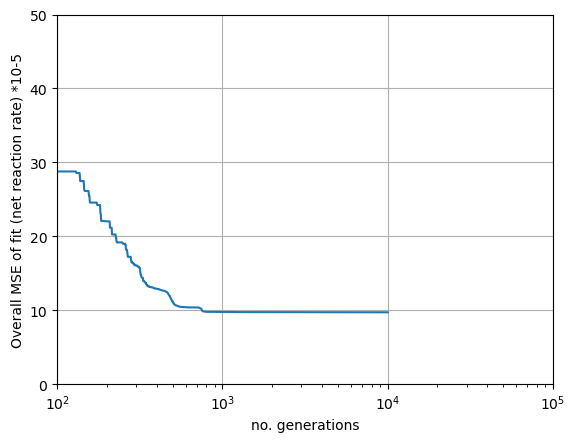

In [32]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [33]:
for i in range(len (res.X)):
    print (res.X[i])

0.32219493878052147
7.827164694669549
7.779558653190917
0.47966300312746857
8.373915216641308
8.298244402058852
8.26306957075616
0.54530860967831
6.5454617333919645
6.615404031510232
6.660383660245613
6.552790485013971
1.154998032977955
7.188457021577452
7.016225298917488
7.338560039085982
7.167352255179948
2.6806896939138705
8.699182603861175
1.6556584518277275
8.625295858884765
8.63107159638978
8.695623545733998
7.685629598191969
1.2710188688184918
7.291136122969276
2.2101883380175473
5.21573039859361
7.203537387333936
7.2414272798860555
1.360056473664893
8.355678999962038
-1.3010299999999997
0.935629930467611


In [34]:
res.X

array([ 0.32219494,  7.82716469,  7.77955865,  0.479663  ,  8.37391522,
        8.2982444 ,  8.26306957,  0.54530861,  6.54546173,  6.61540403,
        6.66038366,  6.55279049,  1.15499803,  7.18845702,  7.0162253 ,
        7.33856004,  7.16735226,  2.68068969,  8.6991826 ,  1.65565845,
        8.62529586,  8.6310716 ,  8.69562355,  7.6856296 ,  1.27101887,
        7.29113612,  2.21018834,  5.2157304 ,  7.20353739,  7.24142728,
        1.36005647,  8.355679  , -1.30103   ,  0.93562993])

In [35]:
# Use stored solution
kr = [1e+01, 10**8.5,10**8.5, # AtoB
      1e+02, 10**9, 10**9, 10**9, # HMGS
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # HMGR
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # MK        
      1e+02, 1e+08, # PMK
      1e+01, 1e+08, 1e+08, 1e+08, 1e+07, # PMD
      1e+01, 1e+07, # IDI 
      1e+03, 1e+06, 1e+08, 1e+08, # GPPS
      1e+01, 1e+08, # LS
      10**0.1] # Vin set to 0.05, ks3
    
import numpy as np
logkr=np.log10(kr)
logkr

array([1. , 8.5, 8.5, 2. , 9. , 9. , 9. , 2. , 8. , 8. , 8. , 8. , 2. ,
       8. , 8. , 8. , 8. , 2. , 8. , 1. , 8. , 8. , 8. , 7. , 1. , 7. ,
       3. , 6. , 8. , 8. , 1. , 8. , 0.1])

In [36]:
for i in range(len (logkr)):
    print (logkr[i])

1.0
8.5
8.5
2.0
9.0
9.0
9.0
2.0
8.0
8.0
8.0
8.0
2.0
8.0
8.0
8.0
8.0
2.0
8.0
1.0
8.0
8.0
8.0
7.0
1.0
7.0
3.0
6.0
8.0
8.0
1.0
8.0
0.10000000000000002


In [37]:
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-2]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

1.0: 0.32219493878052147
8.5: 7.827164694669549
8.5: 7.779558653190917
2.0: 0.47966300312746857
9.0: 8.373915216641308
9.0: 8.298244402058852
9.0: 8.26306957075616
2.0: 0.54530860967831
8.0: 6.5454617333919645
8.0: 6.615404031510232
8.0: 6.660383660245613
8.0: 6.552790485013971
2.0: 1.154998032977955
8.0: 7.188457021577452
8.0: 7.016225298917488
8.0: 7.338560039085982
8.0: 7.167352255179948
2.0: 2.6806896939138705
8.0: 8.699182603861175
1.0: 1.6556584518277275
8.0: 8.625295858884765
8.0: 8.63107159638978
8.0: 8.695623545733998
7.0: 7.685629598191969
1.0: 1.2710188688184918
7.0: 7.291136122969276
3.0: 2.2101883380175473
6.0: 5.21573039859361
8.0: 7.203537387333936
8.0: 7.2414272798860555
1.0: 1.360056473664893
8.0: 8.355678999962038
0.10000000000000002: 0.935629930467611
coeff fit: 0.917982390061656
r: 0.9581139755069101
